#### This is the simulation document for Aske Roelshøjs bachelor-project: "Transducing quantum information between spin qubits and photons" handed in 13 June, 2025.  

#### We will go through each part of the simulation process, commenting on the code on the way. 



In [1]:
#Imports 
from material_parameters import parameters

import numpy as np
from numpy import pi, matmul
from numpy import sin, cos, sqrt, arctan2, pi
from math import atan2

import matplotlib.pyplot as plt 

import time 
import kwant
import kwant.continuum
import tinyarray

import scipy.sparse.linalg as sla

from scipy.constants import physical_constants
from scipy.optimize import minimize
from scipy.optimize import root_scalar

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Get physical constants (all lengths in nm, energies in meV and magnetic field in T)

# Bohr radius in nm

a0 = 1e9*physical_constants["Bohr radius"][0]

# elementary charge in C

e0 = physical_constants["elementary charge"][0]

#hbar in J s

hbar = physical_constants["reduced Planck constant"][0]

# Planck constant in J s
h = physical_constants["Planck constant"][0]

# Vacuum permitivity in F/nm
eps_0 = physical_constants["electric constant"][0] / 1e9  # Convert from F/m to F/nm

# Hartree energy in meV

EH = 1e3*physical_constants["Hartree energy in eV"][0]

# Bohr magneton in meV/T

muB = 1e3*physical_constants["Bohr magneton in eV/T"][0]

# magnetic flux h/e in Tesla.nm^2

phi0 = 2e18*physical_constants["mag. flux quantum"][0]

mu = 0.5 * EH * a0**2

consts = { "mu": mu, "muB": muB, "phi0": phi0}

print(consts)

####

sqrt2 = np.sqrt(2)
sqrt3 = np.sqrt(3)


#Conversion
eV_to_J = 1.602*10**(-19)

# Relative permittivity of Ge heterostructure
eps_Ge = 16.0

# Strain parameters
eps_para = -0.0061
eps_perp = 0.0045

# Define spin-3/2 matrices

id4 = np.identity(4)

Jx = np.array(
    [[0, sqrt3/2, 0, 0], 
     [sqrt3/2, 0, 1, 0], 
     [0, 1, 0, sqrt3/2], 
     [0, 0, sqrt3/2, 0]])

Jy = np.array(
    [[0, -1j*sqrt3/2, 0, 0], 
     [1j*sqrt3/2, 0, -1j, 0], 
     [0, 1j, 0, -1j*sqrt3/2], 
     [0, 0, 1j*sqrt3/2, 0]])

Jz = np.array(
    [[3/2, 0, 0, 0], 
     [0, 1/2, 0, 0], 
     [0, 0, -1/2, 0], 
     [0, 0, 0, -3/2]])


Jyz = matmul(Jy, Jz) + matmul(Jz, Jy)
Jzx = matmul(Jz, Jx) + matmul(Jx, Jz)
Jxy = matmul(Jx, Jy) + matmul(Jy, Jx)
Jx2 = matmul(Jx, Jx)
Jy2 = matmul(Jy, Jy)
Jz2 = matmul(Jz, Jz)
Jx3 = matmul(Jx2, Jx)
Jy3 = matmul(Jy2, Jy)
Jz3 = matmul(Jz2, Jz)

def get_material_parameters(mat):
    for row in parameters:
        if row["Material"] == mat:
            return row

{'mu': 38.09982116140719, 'muB': 0.057883818059999995, 'phi0': 4135.667696}


In [50]:
#Targeted enegy-split in meV
target_freq = 7.5 * 1e9 #in Hz
target_split = target_freq * h *(1/eV_to_J) * 1e3 #meV

#qubit location
z_qubit = 70

#Emitter dipole nm e 
p_val = 0.4*e0 #in nm C

#Decay rate
decay_rate = 2*np.pi*150 #MHz

In [4]:
#1 dot parameters
#To compute please use this: 
# box of computation
L = 120
W = 120
H = 20

# gate position and dimension in nm

x0 = L/2
y0 = W/2
Lg = 80

# Distance to quantum well in nm
d_QW = 60

#real dimensions
L_SQD_real = 250
W_SQD_real = 250
H_SQD_real = 100

#Gate voltage in mV
V_SQD = -1000 #mV

# Parameter for definition of computation lattice

ax, ay, az = 4, 4, 1

lat_params_SQD = {"L": L, "W": W, "H": H, "ax": ax, "ay": ay, "az": az}
print('Lattice parameters (lengths in nm): {}'.format(lat_params_SQD))

lat_params_SQD_realdim = {"L": L_SQD_real, "W": W_SQD_real, "H": H, "ax": ax, "ay": ay, "az": az}

nx, ny, nz = int(L/ax - 1), int(W/ay - 1), int(H/az - 1)
print('Number of points in the lattice: {0}*{1}*{2}={3}'.format(nx, ny, nz, nx*ny*nz))

#Location of the spin qubit in the SQD
spin_qubit_loc_SQD = [L_SQD_real/2, W_SQD_real/2, z_qubit]

print(lat_params_SQD["L"])
print(spin_qubit_loc_SQD)

Lattice parameters (lengths in nm): {'L': 120, 'W': 120, 'H': 20, 'ax': 4, 'ay': 4, 'az': 1}
Number of points in the lattice: 29*29*19=15979
120
[125.0, 125.0, 70]


In [30]:
#2 dot parameters

#Box of computation
L_DQD = 280
W_DQD = 120
H_DQD = 20
z_dist = 60 #distance from dot to gates

#Real dimensions 
L_DQD_real = 500 #nm
W_DQD_real = 300 #nm 
dqw = 180 #distance between the 2 quantum wells

#Array of voltages for DQD
V_array = [-200, -200, -130] #mV #VL, VR, VBarrier

#Lattrice parameters for DQD
lat_params_DQD = {"L": L_DQD, "W": W_DQD, "H": H_DQD, "ax": ax, "ay": ay, "az": az}
print('Lattice parameters (lengths in nm): {}'.format(lat_params_DQD))

#Number of points in the lattice for DQD
nx_DQD, ny_DQD, nz_DQD = int(L_DQD/ax - 1), int(W_DQD/ay - 1), int(H_DQD/az - 1)
print('Number of points in the lattice: {0}*{1}*{2}={3}'.format(nx_DQD, ny_DQD, nz_DQD, nx_DQD*ny_DQD*nz_DQD))

#Location of the spin qubit in the SQD
spin_qubit_loc_DQD = [L_DQD_real/2, W_DQD_real/2, z_qubit]


print(lat_params_DQD["L"])
print(spin_qubit_loc_DQD)

Lattice parameters (lengths in nm): {'L': 280, 'W': 120, 'H': 20, 'ax': 4, 'ay': 4, 'az': 1}
Number of points in the lattice: 69*29*19=38019
280
[250.0, 150.0, 70]


#### Some of the code below is borrowed from https://github.com/kathrinekuszon/simulation_framework, but we have made some adjustments to integrate it into our system. We have adjusted the box of computation and the z-lattice parameter ($a_z$), and adapted it to our document and notation.  

In [31]:
#Here we the box of computation for the 3D system.
def box_3D_SQD(site):
    (x, y, z) = site.pos
    return 0 <= x < L - ax and 0 <= y < W - ay and 0 <= z < H - az

def box_3D_DQD(site):
    (x, y, z) = site.pos
    return 0 <= x < L_DQD - ax and 0 <= y < W_DQD - ay and 0 <= z < H_DQD - az

#This is the Hamiltonian for the spin qubit, Eq. 3.1 in the paper
H_LKBP = ("""
    mu * ((ga1 + 5*ga2/2) * (k_x**2 + k_y**2 + k_z**2 + 2 * k_x * Ax(y,z) + 2 * k_y * Ay(x,z)) * id4 
    - 2 * ga2 * (k_x**2 * Jx2 + k_y**2 * Jy2 + k_z**2 * Jz2 + 2 * k_x * Ax(y,z) * Jx2 + 2 * k_y * Ay(x,z) * Jy2) 
    - ga3 * (kyz * Jyz + kzx * Jzx + kxy * Jxy 
    + (k_z * Ay(x,z) + Ay(x,z) * k_z) * Jyz + (k_z * Ax(y,z) + Ax(y,z) * k_z) * Jzx 
    + (k_x * Ay(x,z) + Ax(y,z) * k_y + k_y * Ax(y,z) + Ay(x,z) * k_x) * Jxy)) 
    + 2 * muB * (ka * (Jx*Bx + Jy*By + Jz*Bz) + qu * (Jx3*Bx + Jy3*By + Jz3*Bz)) 
    + V(x, y, z) * id4
    + bv * (epsxx * Jx2 + epsyy * Jy2 + epszz * Jz2)
    """)


In [ ]:
#In this cell we use KWANT to make the model and discretize Eq. 3.1. We return our system, which we will retrieve to compute Delta_01 and x_01, y_01, z_01.
def make_model_LKBP_SQD(H_LK, mat_params, lat_params, B):
    syst = kwant.Builder() #Builds system. 
    #Load material parameters and update the constants
    subs = consts
    subs.update(mat_params)
    subs.update(lat_params)
    subs.update({
        "Bx": B[0], "By": B[1], "Bz": B[2],
        "kyz": "k_y * k_z + k_z * k_y",
        "kzx": "k_z * k_x + k_x * k_z",
        "kxy": "k_x * k_y + k_y * k_x",
        "id4": id4, "Jx": Jx, "Jy": Jy, "Jz": Jz,
        "Jx2": Jx2, "Jy2": Jy2, "Jz2": Jz2,
        "Jyz": Jyz, "Jzx": Jzx, "Jxy": Jxy,
        "Jx3": Jx3, "Jy3": Jy3, "Jz3": Jz3,
        "epsxx": eps_para, "epsyy": eps_para, "epszz":eps_perp
        })

    model = kwant.continuum.discretize(H_LK, locals=subs, grid=kwant.lattice.general([(ax, 0, 0), (0, ay, 0), (0, 0, az)], norbs=4)) #Builds the model with the discretized Hamiltonian.
    syst.fill(model, box_3D_SQD, (0, 0, 0)) #Apply it to our system. 
    syst = syst.finalized()
    return syst

def make_model_LKBP_DQD(H_LK, mat_params, lat_params, B):
    syst = kwant.Builder()
    subs = consts
    subs.update(mat_params)
    subs.update(lat_params)
    subs.update({
        "Bx": B[0], "By": B[1], "Bz": B[2],
        "kyz": "k_y * k_z + k_z * k_y",
        "kzx": "k_z * k_x + k_x * k_z",
        "kxy": "k_x * k_y + k_y * k_x",
        "id4": id4, "Jx": Jx, "Jy": Jy, "Jz": Jz,
        "Jx2": Jx2, "Jy2": Jy2, "Jz2": Jz2,
        "Jyz": Jyz, "Jzx": Jzx, "Jxy": Jxy,
        "Jx3": Jx3, "Jy3": Jy3, "Jz3": Jz3,
        "epsxx": eps_para, "epsyy": eps_para, "epszz":eps_perp
        })

    model = kwant.continuum.discretize(H_LK, locals=subs, grid=kwant.lattice.general([(ax, 0, 0), (0, ay, 0), (0, 0, az)], norbs=4))
    syst.fill(model, box_3D_DQD, (0, 0, 0))
    syst = syst.finalized()
    return syst

#### In the cell below we define the gate-potentials using Eq. 3.4, 3.5 and 3.6. 

In [ ]:
#Define Eq. 3.5;
def g(x,y,z):
        return (0.5 / np.pi) * np.arctan2(x * y, (z * np.sqrt(x**2 + y**2 + z**2)))

#In here we also define the vector potential defined under Eq. 3.2.  
def compute_eigs_SQD(syst, B, V, N=8):
    def potential_vector_x(y, z):
        return (2*pi/phi0) * (z * B[1] - y * B[2] / 2)
    def potential_vector_y(x, z):
        return (2*pi/phi0) * (- z * B[0] + x * B[2] / 2)
    def potential(x, y, z):
        L = x0 - 0.5*Lg # Left and right x-coordinates of the dot
        R = x0 + 0.5*Lg  
        B = y0 - 0.5*Lg # Bottom and top y-coordinates of the dot
        T = y0 + 0.5*Lg
        return V * (g(x - L, y - B, z + d_QW) + g(x - L, T - y, z + d_QW) + g(R - x, y - B, z + d_QW) + g(R - x, T - y, z + d_QW))
    #Pick out the submatrix, and diagonalize it to get the eigenvalues and eigenvectors.   
    Ham = syst.hamiltonian_submatrix(params=dict(V=potential, Ax=potential_vector_x, Ay=potential_vector_y), sparse=True)
    evals, evecs = sla.eigsh(Ham, k=N, which='SA') #which = SA returns smallest eigenvalues
    idx = evals.argsort()
    return [evals[idx], evecs[:,idx]]

#Using Eq. 3.6 to defined the potential for DQD setup. 
def compute_eigs_DQD(syst, B, V=[-200, -200, -130], N=8):
    V_left, V_right, V_barrier = V[0], V[1], V[2] #mV
    x0_left_center, x0_right_center = (L_DQD-dqw)/2 - 1, (L_DQD+dqw)/2 - 1 #Define the center of the left and right dot, separeted by d_qw. 
    y0_center = W_DQD/2  - 1 
    x0_barrier_gate_center = L_DQD/2  - 1

    def potential_vector_x(y, z):
        return (2*pi/phi0) * (z * B[1] - y * B[2] / 2)
    def potential_vector_y(x, z):
        return (2*pi/phi0) * (- z * B[0] + x * B[2] / 2)
    #Define the potential of each dot. First left, then right, then barrier. We calculate each corner of the metallic gate. 
    def left_potential(x, y, z):
        L = x0_left_center - 0.5*Lg 
        R = x0_left_center + 0.5*Lg  
        B = y0_center - 0.5*Lg 
        T = y0_center + 0.5*Lg
        return V_left * (g(x - L, y - B, z + z_dist) + g(x - L, T - y, z + z_dist) + g(R - x, y - B, z + z_dist) + g(R - x, T - y, z + z_dist)) #And then assemble. 
    
    def right_potential(x, y, z):
        L = x0_right_center - 0.5*Lg # Left and right x-coordinates of the dot
        R = x0_right_center + 0.5*Lg  
        B = y0_center - 0.5*Lg # Bottom and top y-coordinates of the dot
        T = y0_center + 0.5*Lg
        return V_right * (g(x - L, y - B, z + z_dist) + g(x - L, T - y, z + z_dist) + g(R - x, y - B, z + z_dist) + g(R - x, T - y, z + z_dist))
    #Barrier, different V
    def barrier_potential(x, y, z):
        L = x0_barrier_gate_center - 0.5*Lg # Left and right x-coordinates of the dot
        R = x0_barrier_gate_center + 0.5*Lg  
        B = y0_center - 0.5*Lg # Bottom and top y-coordinates of the dot
        T = y0_center + 0.5*Lg
        return V_barrier * (g(x - L, y - B, z + z_dist) + g(x - L, T - y, z + z_dist) + g(R - x, y - B, z + z_dist) + g(R - x, T - y, z + z_dist))
    #The total potential is computed using Eq. 3.6. 
    def potential (x,y,z):
        V_tot = (left_potential(x,y,z) + right_potential(x,y,z) + barrier_potential(x,y,z))
        return V_tot
    #Again we diagonalize the Hamiltonian to get the eigenvalues and eigenvectors.
    Ham = syst.hamiltonian_submatrix(params=dict(V=potential, Ax=potential_vector_x, Ay=potential_vector_y), sparse=True)
    evals, evecs = sla.eigsh(Ham, k=N, which='SA') #which = SA returns smallest eigenvalues
    idx = evals.argsort()
    return [evals[idx], evecs[:,idx]]

In [ ]:
#Here we retrieve the material parameters for the spin qubit.
mat = 'Ge'
mat_params = get_material_parameters(mat)
print('Material parameters: {}'.format(mat_params))

Material parameters: {'Material': 'Ge', 'ga1': 13.38, 'ga2': 4.24, 'ga3': 5.69, 'ka': 3.41, 'qu': 0.06, 'bv': -2860.0, 'nu': 0.73}


In [ ]:
#Now we can compute the spin splitting for the SQD and DQD setups, by using the functions defined above.
def Delta_s_SQD(mat_params, lat_params, B, V):
    print('Computing spin splitting for 1 well magnetic field B = {0} T and gate voltage Vg = {1:.1f} mV'.format(B, V))
    t1 = time.time()
    syst = make_model_LKBP_SQD(H_LKBP, mat_params, lat_params, B) #Retrieve the system.
    evals = compute_eigs_SQD(syst, B, V)[0] #Retrieve the eigenvalues.
    Ds = evals[1] - evals[0] #Compute energy-split. 
    t2 = time.time()
    print('1 well spin splitting: {0:.6f} meV (done in {1:.2f}s).'.format(Ds, t2 - t1))
    return Ds 

def Delta_s_DQD(mat_params, lat_params, B):
    print('Computing spin splitting for 2 well with magnetic field B = {0} T'.format(B))
    t1 = time.time()
    syst = make_model_LKBP_DQD(H_LKBP, mat_params, lat_params, B)
    evals = compute_eigs_DQD(syst, B)[0]
    Ds = evals[1] - evals[0]
    t2 = time.time()
    print('2 well spin splitting: {0:.6f} meV (done in {1:.2f}s).'.format(Ds, t2 - t1))
    return Ds


#### A part of the setup-proces was determining the magnetic field. As described in the paper, for SQD we let B_x=B_y=0.35T and for DQD we let B_y=B_z=0T, and solved for the last component. To solve, we used the function below. 

In [ ]:
#Function to find the magnetic field component for a given target gap. This function uses root_scalar to find the solution, with the bisection method, i.e. it jumps between B_min and B_max until it finds the solution.
def find_b_component_for_gap(target_gap, component, mat_params, lat_params, V, is_DQD=False, B_fixed=None, B_min=1e-6, B_max=2.0, tol=1e-5): #We defined target gap, what component to solve for, whether it is SQD or DQD, the fixed values and min and max values for, and at last the tolerance.
    cord = {'x': 0, 'y': 1, 'z': 2}[component] #Pick out the component you want to solve for. 
    #root_scalar needs a function to find the root of, so we define a function that computes the distance between the energy gap for a given value of B and the target.
    def gap_func(Bval):
        B = [0.0, 0.0, 0.0]
        if B_fixed is not None: 
            #We fill out all components other than the one we want to solve for. 
            fixed_indices = [i for i in range(3) if i != cord]
            for fix_val, fix_comp in enumerate(fixed_indices):
                B[fix_comp] = B_fixed[fix_val]
        B[cord] = Bval #What we want to solve for.
        if is_DQD: #Whether it is SQD or DQD. 
            gap = Delta_s_DQD(mat_params, lat_params, B) 
        else:
            gap = Delta_s_SQD(mat_params, lat_params, B, V)
        return gap - target_gap #Returns the difference. Root_scalars finds the B which makes this zero. 
    #Then we find the solution. 
    sol = root_scalar(gap_func, bracket=[B_min, B_max], method='bisect', xtol=tol)
    if sol.converged:
        print(f"Found B_{component} = {sol.root:.6f} T for target gap {target_gap:.6f} meV")
        return sol.root
    else: #If it does not converge, return None. 
        print("Did not converge.")
        return None

#Here we find the components. 
find_b_component_for_gap(target_gap=target_split, component='z', mat_params=mat_params, lat_params=lat_params_SQD, V=-1000, is_DQD=False, B_fixed = [0.35, 0.35], B_min=1e-6, B_max=2.0, tol=1e-5) #For SQD. 
find_b_component_for_gap(target_gap=target_split, component='x', mat_params=mat_params, lat_params=lat_params_SQD, V=-1000, is_DQD=True, B_fixed = [0, 0], B_min=1e-6, B_max=2.0, tol=1e-5) #For DQD.

Computing spin splitting for 1 well magnetic field B = [0.35, 0.35, 1e-06] T and gate voltage Vg = -1000.0 mV
1 well spin splitting: 0.000743 meV (done in 13.08s).
Computing spin splitting for 1 well magnetic field B = [0.35, 0.35, 2.0] T and gate voltage Vg = -1000.0 mV
1 well spin splitting: 1.736078 meV (done in 10.28s).
Computing spin splitting for 1 well magnetic field B = [0.35, 0.35, 1.0000005] T and gate voltage Vg = -1000.0 mV
1 well spin splitting: 0.831537 meV (done in 11.56s).
Computing spin splitting for 1 well magnetic field B = [0.35, 0.35, 0.50000075] T and gate voltage Vg = -1000.0 mV
1 well spin splitting: 0.411146 meV (done in 16.55s).
Computing spin splitting for 1 well magnetic field B = [0.35, 0.35, 0.250000875] T and gate voltage Vg = -1000.0 mV
1 well spin splitting: 0.205097 meV (done in 18.05s).
Computing spin splitting for 1 well magnetic field B = [0.35, 0.35, 0.1250009375] T and gate voltage Vg = -1000.0 mV
1 well spin splitting: 0.102520 meV (done in 14.27

1.922233620426178

#### Having determined the magnetic fields, we are ready to retrieve the transition matrix elements. 

In [39]:
def Ds_SQD_d01(mat_params, lat_params, B, V):
    t1 = time.time()
    print('Computing spin splitting and electric dipole moments for 1 qd with magnetic field B = {0} T and gate voltage Vg = {1:.1f} mV'.format(B, V))
    syst = make_model_LKBP_SQD(H_LKBP, mat_params, lat_params, B) #Retrieve system and energy-split.
    eigs = compute_eigs_SQD(syst, B, V)
    evals = eigs[0]
    Ds = evals[1] - evals[0]
    print('Ds = {0} meV'.format(Ds))
    #Then we build the lattice for our wavefunctions. 
    norbs = 4 #First four levels. 
    x = np.arange(0, L - ax, ax)
    y = np.arange(0, W - ay, ay)
    z = np.arange(0, H - az, az)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    
    grid_shape = np.shape(X)
    
    # Get the wavefunctions for the first two levels
    psi0 = eigs[1][:, 0].reshape((int(L/ax - 1) * int(W/ay - 1) * int(H/az - 1), norbs))
    psi1 = eigs[1][:, 1].reshape((int(L/ax - 1) * int(W/ay - 1) * int(H/az - 1), norbs))
    
    # Compute matrix element for each spinor component
    integral_x01 = integral_y01 = integral_z01 = integral_xl = integral_yl = integral_zl = 0.0 + 0.0j 
    norm0 = norm1 = 0.0 #Normalization factor. 
    
    #Then we compute the matrix elements as defined in Eq. 3.10. 
    for i in range(4):
        psi0_i = psi0[:, i].reshape(grid_shape)
        psi1_i = psi1[:, i].reshape(grid_shape)
        norm0 += np.sum(np.conj(psi0_i)*psi0_i)
        norm1 += np.sum(np.conj(psi1_i)*psi1_i)
        integral_x01 += np.sum(np.conj(psi0_i) * X * psi1_i)
        integral_y01 += np.sum(np.conj(psi0_i) * Y * psi1_i) 
        integral_z01 += np.sum(np.conj(psi0_i) * Z * psi1_i)
        integral_xl += np.sum(np.conj(psi1_i) * X * psi1_i - np.conj(psi0_i) * X * psi0_i) 
        integral_yl += np.sum(np.conj(psi1_i) * Y * psi1_i - np.conj(psi0_i) * Y * psi0_i) 
        integral_zl += np.sum(np.conj(psi1_i) * Z * psi1_i - np.conj(psi0_i) * Z * psi0_i)
    #And return the results.
    print(norm0, norm1)
    x01 = np.abs(integral_x01)
    y01 = np.abs(integral_y01)
    z01 = np.abs(integral_z01)
    xl = np.abs(integral_xl)
    yl = np.abs(integral_yl)
    zl = np.abs(integral_zl)
    t2 = time.time()
    print('x01_1well = {0:.5f} nm'.format(x01))
    print('y01_1well = {0:.5f} nm'.format(y01))
    print('z01_1well = {0:.5f} nm'.format(z01))
    #print('xl_1well = {0:.5f} nm'.format(xl))
    #print('yl_1well = {0:.5f} nm'.format(yl))
    #print('zl_1well = {0:.5f} nm'.format(zl))
    #print('Done in {0:3f} s'.format(t2-t1))
    return [Ds, x01, y01, z01, xl, yl, zl, psi0, psi1] #Return the energy-split and the matrix elements.

#Same for the DQD setup.
def Ds_DQD_d01(mat_params, lat_params, B):
    t1 = time.time()
    print('Computing spin splitting and electric dipole moments for 2 qds with magnetic field B = {0} T and V_L=V_R = -200mV and barrier potential V_B= -130mV'.format(B))
    syst = make_model_LKBP_DQD(H_LKBP, mat_params, lat_params, B)
    eigs = compute_eigs_DQD(syst, B)
    evals = eigs[0]
    Ds = evals[1] - evals[0]
    print('Ds = {0} meV'.format(Ds))
    
    norbs = 4
    x = np.arange(0, L_DQD - ax, ax)
    y = np.arange(0, W_DQD - ay, ay)
    z = np.arange(0, H_DQD - az, az)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    
    grid_shape = X.shape  # (nx, ny, nz)
    n_points = np.prod(grid_shape)
    
    # Get the wavefunctions for the first two levels
    psi0 = eigs[1][:, 0].reshape((n_points, norbs))
    psi1 = eigs[1][:, 1].reshape((n_points, norbs))
    
    # Compute matrix element for each spinor component
    integral_x01 = integral_y01 = integral_z01 = integral_xl = integral_yl = integral_zl = 0.0 + 0.0j 
    norm0 = norm1 = 0.0
    
    for i in range(4):
        psi0_i = psi0[:, i].reshape(grid_shape)
        psi1_i = psi1[:, i].reshape(grid_shape)
        norm0 += np.sum(np.conj(psi0_i)*psi0_i)
        norm1 += np.sum(np.conj(psi1_i)*psi1_i)
        integral_x01 += np.sum(np.conj(psi0_i) * X * psi1_i)
        integral_y01 += np.sum(np.conj(psi0_i) * Y * psi1_i) 
        integral_z01 += np.sum(np.conj(psi0_i) * Z * psi1_i)
        integral_xl += np.sum(np.conj(psi1_i) * X * psi1_i - np.conj(psi0_i) * X * psi0_i) 
        integral_yl += np.sum(np.conj(psi1_i) * Y * psi1_i - np.conj(psi0_i) * Y * psi0_i) 
        integral_zl += np.sum(np.conj(psi1_i) * Z * psi1_i - np.conj(psi0_i) * Z * psi0_i)

    print(norm0, norm1)
    x01 = np.abs(integral_x01)
    y01 = np.abs(integral_y01)
    z01 = np.abs(integral_z01)
    xl = np.abs(integral_xl)
    yl = np.abs(integral_yl)
    zl = np.abs(integral_zl)
    t2 = time.time()
    print('x01_2well = {0:.5f} nm'.format(x01))
    print('y01_2well = {0:.5f} nm'.format(y01))
    print('z01_2well = {0:.5f} nm'.format(z01))
    #print('xl_2well = {0:.5f} nm'.format(xl))
    #print('yl_2well = {0:.5f} nm'.format(yl))
    #print('zl_2well = {0:.5f} nm'.format(zl))
    #print('Done in {0:3f} s'.format(t2-t1))
    return [Ds, x01, y01, z01, xl, yl, zl, psi0, psi1]


#### Having settled on specific magnetic fields, we run the simulation. 

In [40]:
#Run simulation for final parameters
params_SQD = Ds_SQD_d01(mat_params=mat_params, lat_params=lat_params_SQD, B= [0.35, 0.35, 0.037805], V=-1000)  
params_DQD = Ds_DQD_d01(mat_params=mat_params, lat_params=lat_params_DQD, B=[1.92242431640625,0,0])

Computing spin splitting and electric dipole moments for 1 qd with magnetic field B = [0.35, 0.35, 0.037805] T and gate voltage Vg = -1000.0 mV
Ds = 0.03101995912712141 meV
(1.0000000000001033+0j) (1.0000000000001061+0j)
x01_1well = 0.00016 nm
y01_1well = 0.00016 nm
z01_1well = 0.00020 nm
Computing spin splitting and electric dipole moments for 2 qds with magnetic field B = [1.92242431640625, 0, 0] T and V_L=V_R = -200mV and barrier potential V_B= -130mV
Ds = 0.031024842364175242 meV
(1.0000000000002243+0j) (1.000000000000243+0j)
x01_2well = 1.96790 nm
y01_2well = 0.00000 nm
z01_2well = 0.00000 nm


#### Now we want to simulate the electric field using Eq. 3.11. 

In [41]:
#Simulating electric field of emitter
def compute_emit_field(p_emit, emit_loc, pos):
    r_vec = np.array(pos)-np.array(emit_loc) #Distance vector from emitter to point of interest

    r = np.sqrt(r_vec[0]**2 + r_vec[1]**2 + r_vec[2]**2) #Magnitude of the distance vector
    theta = np.arctan2(np.sqrt(r_vec[0]**2 + r_vec[1]**2), r_vec[2]) #Polar angle
    phi = np.arctan2(r_vec[1], r_vec[0]) #Azimuthal angle

    r_hat = np.array([sin(theta)*cos(phi), sin(theta)*sin(phi), cos(theta)]) #Unit vector in the direction of r
    p_vec = np.array(p_emit) #Dipole moment vector

    prefac = 1/(4*np.pi*eps_0*r**3) #Prefactor for the electric field due to a dipole

    E = (prefac*(3*(np.dot(p_vec, r_hat))*r_hat - p_vec)) #Electric field vector at the point of interest

    return E #in V/nm since r is in nm and p_emit is in nm C

#Simulating electric field of emitter in Ge slab
def compute_dielecGe_emit_field(p_emit, emit_loc, pos):
    r_vec = np.array(pos)-np.array(emit_loc)

    r = np.sqrt(r_vec[0]**2 + r_vec[1]**2 + r_vec[2]**2)
    theta = np.arctan2(np.sqrt(r_vec[0]**2 + r_vec[1]**2), r_vec[2])
    phi = np.arctan2(r_vec[1], r_vec[0])

    r_hat = np.array([sin(theta)*cos(phi), sin(theta)*sin(phi), cos(theta)])
    p_vec = np.array(p_emit)

    prefac = 1/(4*np.pi*eps_0*eps_Ge*r**3) # Using eps = eps_0*eps_r^Ge 

    E = (prefac*(3*(np.dot(p_vec, r_hat))*r_hat - p_vec))

    return E #in V/nm

#### Then we make a function to compute the coupling using Eq. 2.6, such that we can input different distances to investigate how the proximity affects g. 

In [44]:
#Computes coupling
def compute_coupling(p_emit, emit_loc, spin_loc):
    x0_SQD, y0_SQD, z0_SQD = params_SQD[1:4] #Pulls the values
    x0_DQD, y0_DQD, z0_DQD = params_DQD[1:4]

    dp_matrix_SQD = (np.array([x0_SQD, y0_SQD, z0_SQD])*e0) / 1e9 #Then we make the transition dipole moment vector using Eq. 3.9. Units are in C*m when dividing through 1e9.
    dp_matrix_DQD = (np.array([x0_DQD, y0_DQD, z0_DQD])*e0) / 1e9

    E = compute_emit_field(p_emit, emit_loc, pos=spin_loc) * 1e9 #Compute the electric field at the qubit, here in V/m when multiplying by 1e9.

    g_s_SQD = 2*np.pi* np.dot(dp_matrix_SQD, E)/h #Then we compute g using Eq. 2.6. 
    g_s_DQD = 2*np.pi* np.dot(dp_matrix_DQD, E)/h

    return np.array([g_s_SQD, g_s_DQD]) #Return coupling for SQD and DQD given in Hz
#Same for coulping in Ge slab assuming epsilon. 
def compute_dielecGe_coupling(p_emit, emit_loc, spin_loc):
    x0_SQD, y0_SQD, z0_SQD = params_SQD[1:4]
    x0_DQD, y0_DQD, z0_DQD = params_DQD[1:4]

    dp_matrix_SQD = (np.array([x0_SQD, y0_SQD, z0_SQD])*e0) / 1e9
    dp_matrix_DQD = (np.array([x0_DQD, y0_DQD, z0_DQD])*e0) / 1e9

    E = compute_dielecGe_emit_field(p_emit, emit_loc, pos=spin_loc) * 1e9

    g_s_SQD = 2*np.pi* np.dot(dp_matrix_SQD, E)/h
    g_s_DQD = 2*np.pi* np.dot(dp_matrix_DQD, E)/h

    return np.array([g_s_SQD, g_s_DQD]) #in Hz

#### Then we make distance lists, to examine proximity.

In [45]:
#Arrays to range the distances for the SQD and DQD.
dist_xranges_SQD = np.linspace(L_SQD_real-25, L_SQD_real+75, num=1000)
dist_yranges_SQD = np.linspace(W_SQD_real-25, W_SQD_real + 75, num=1000)

dist_xranges_DQD = np.linspace(L_DQD_real-25, L_DQD_real + 75, num=1000)
dist_yranges_DQD = np.linspace(W_DQD_real-25, W_DQD_real +75, num=1000)

dist_zranges = np.linspace(1, 200, num=1000)


def make_SQD_lists(dist_xrange, dist_yrange, dist_zrange, spin_qubit_loc):
    x_spin, y_spin, z_spin = spin_qubit_loc[0], spin_qubit_loc[1], spin_qubit_loc[2] 

    x_list = [[a, y_spin, z_spin] for a in dist_xrange]
    y_list = [[x_spin, a, z_spin] for a in dist_yrange]
    z_list = [[L_SQD_real+10, y_spin, a] for a in dist_zrange]

    return x_list, y_list, z_list

def make_DQD_lists(dist_xrange, dist_yrange, dist_zrange, spin_qubit_loc):
    x_spin, y_spin, z_spin = spin_qubit_loc[0], spin_qubit_loc[1], spin_qubit_loc[2] 

    x_list = [[a, y_spin, z_spin] for a in dist_xrange]
    y_list = [[x_spin, a, z_spin] for a in dist_yrange]
    z_list = [[L_DQD_real+10, y_spin, a] for a in dist_zrange]

    return x_list, y_list, z_list

def make_SQD_dists(dist_xrange, dist_yrange, dist_zrange, spin_qubit_loc):
    x_spin, y_spin, z_spin = L_SQD_real, W_SQD_real, spin_qubit_loc[2] 

    dx_list = [(a-x_spin) for a in dist_xrange]
    dy_list = [(a-y_spin) for a in dist_yrange]
    dz_list = dist_zrange

    return dx_list, dy_list, dz_list
def make_DQD_dists(dist_xrange, dist_yrange, dist_zrange, spin_qubit_loc):
    x_spin, y_spin, z_spin = L_DQD_real, W_DQD_real, spin_qubit_loc[2] 

    dx_list = [(a-x_spin) for a in dist_xrange]
    dy_list = [(a-y_spin) for a in dist_yrange]
    dz_list = dist_zrange

    return dx_list, dy_list, dz_list


dist_lists_SQD = make_SQD_lists(dist_xranges_SQD, dist_yranges_SQD, dist_zranges, spin_qubit_loc_SQD)
dist_lists_DQD = make_DQD_lists(dist_xranges_DQD, dist_yranges_DQD, dist_zranges, spin_qubit_loc_DQD)

#### Then we plot g vs. coordinates. This is just unpacking the above found values and formatting plots. Here we make Fig. (4.1) and Fig. (4.2), and the plots in Appendix B. 

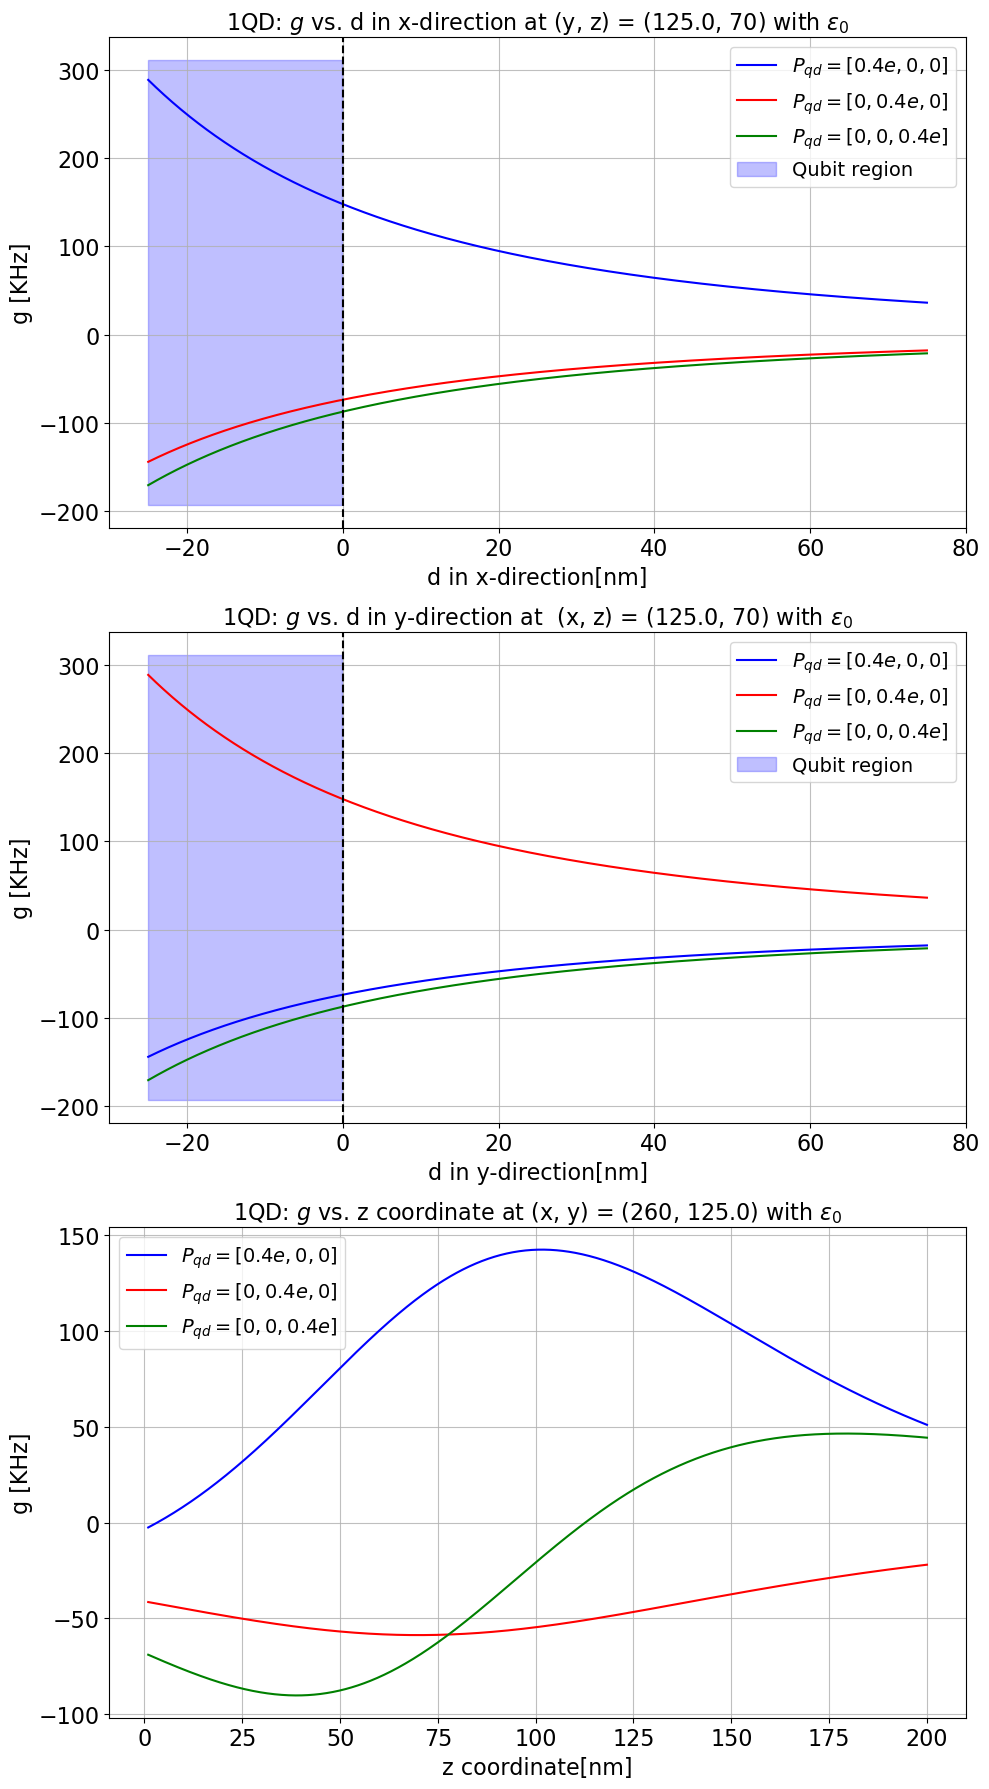

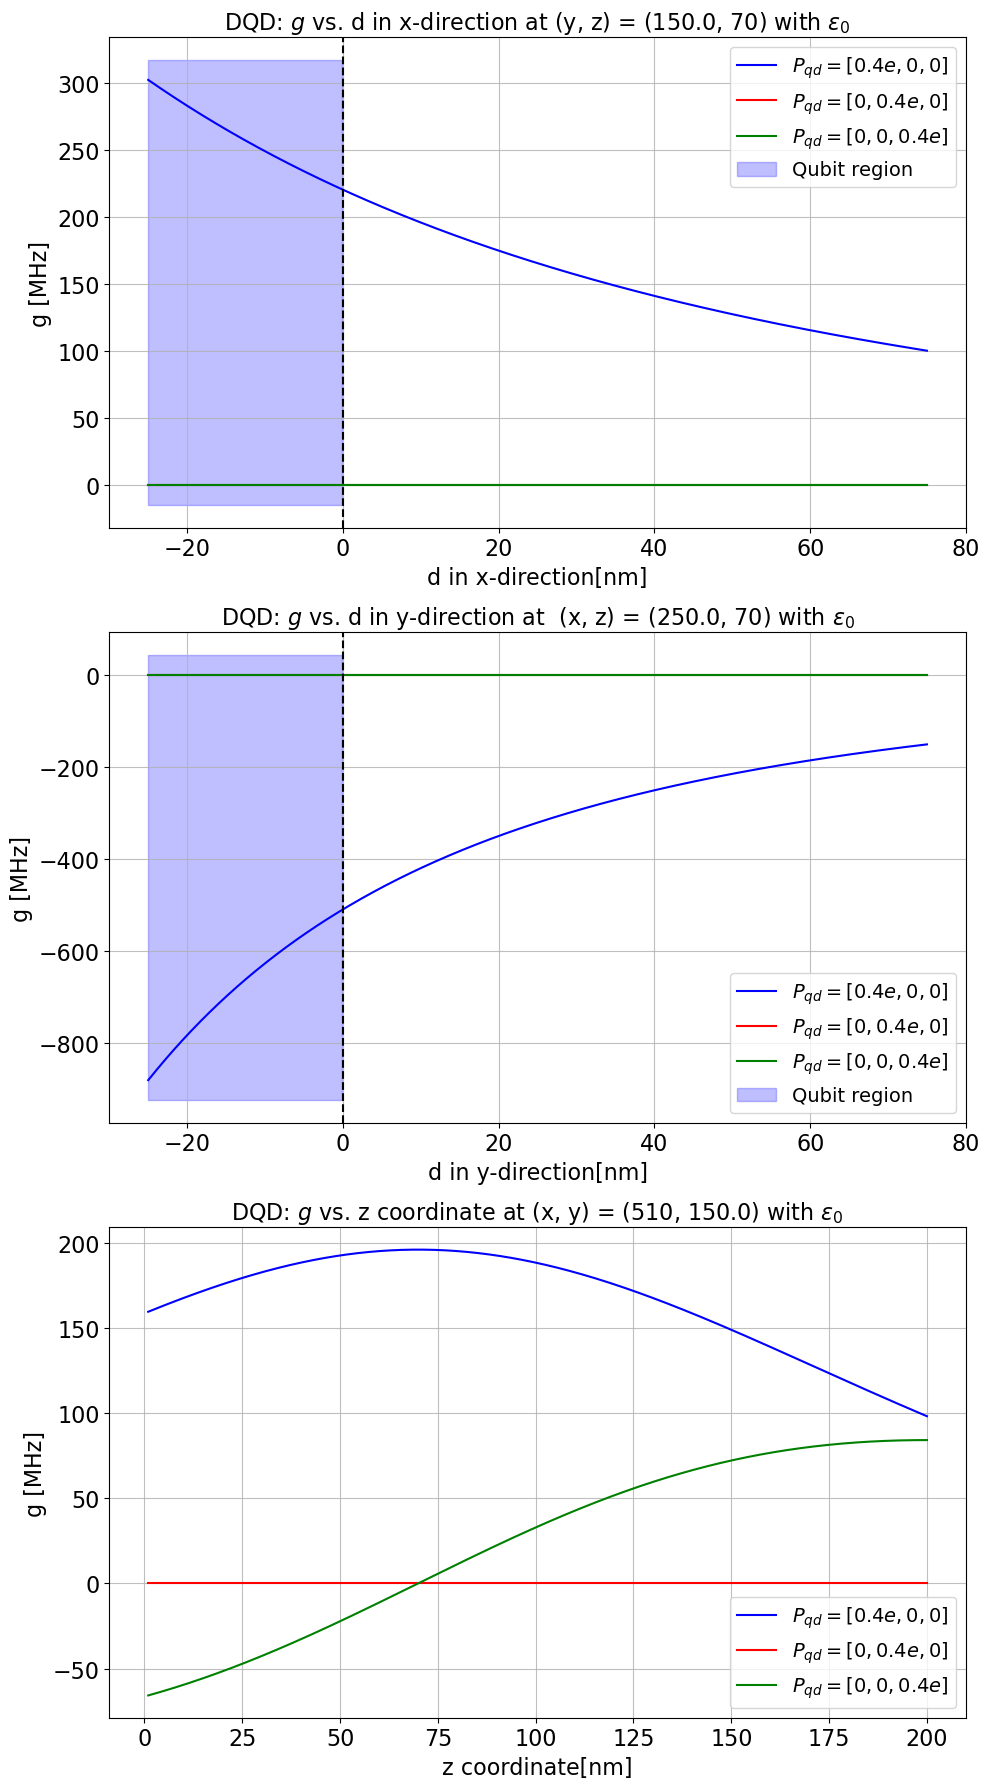

[[[302.36476000627675,
   301.9615622463212,
   301.55908104341313,
   301.1573148064411,
   300.7562619485319,
   300.3559208870369,
   299.95629004351866,
   299.5573678437385,
   299.1591527176428,
   298.7616430993508,
   298.36483742714137,
   297.9687341434389,
   297.57333169480296,
   297.1786285319134,
   296.78462310955814,
   296.3913138866212,
   295.99869932606896,
   295.60677789493826,
   295.2155480643239,
   294.8250083093654,
   294.435157109235,
   294.0459929471259,
   293.65751431023784,
   293.2697196897678,
   292.88260758089405,
   292.49617648276717,
   292.1104248984963,
   291.72535133513634,
   291.34095430367745,
   290.9572323190318,
   290.5741839000215,
   290.1918075693678,
   289.810101853677,
   289.4290652834309,
   289.04869639297334,
   288.66899372049846,
   288.28995580803996,
   287.9115812014584,
   287.5338684504292,
   287.15681610843245,
   286.7804227327393,
   286.404686884402,
   286.029607128242,
   285.6551820328373,
   285.281410170512

In [ ]:
#First for SQD. 
def g_SQD_plotter(dist_x_ranges, dist_y_ranges, dist_z_range, spin_loc, p_val): 
    x_list, y_list, z_list = make_SQD_lists(dist_x_ranges, dist_y_ranges, dist_z_range, spin_loc) #Retrieve lists. 
    labels = ['d in x-direction', 'd in y-direction', 'z coordinate'] #Labels for plotting. 
    well_dim_labels = ['Qubit region', 'Qubit region', 'Qubit z-location']
    well_dim = [L_SQD_real, W_SQD_real, z_qubit] #Dimensions for titles. 

    other_pos = [f'(y, z) = ({x_list[0][1]}, {x_list[0][2]})', f' (x, z) = ({y_list[0][0]}, {y_list[0][2]})', f'(x, y) = ({z_list[0][0]}, {z_list[0][1]})'] #For titles. 

    dipoles = [[p_val, 0, 0], [0, p_val, 0], [0, 0, p_val]] #Different orientations for the dipole moments. 
    dipole_labels = ['$P_{qd} = [0.4e,0,0]$', '$P_{qd} = [0,0.4e,0]$', '$P_{qd} = [0,0,0.4e]$'] #Labels.

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 18)) #Subplots. 
    fig.subplots_adjust(hspace=0.3, wspace=0.25)
    axes = [ax1, ax2, ax3]

    colors_vac = ['b', 'r', 'g'] #To get coloring consistency. 

    g_collective = [] #Array to collect the g values for each dipole orientation and distances.
    #Loop over the three axes, and plot the coupling for each dipole orientation.
    for i in range(3):
        g_col_intermediate = []
        for j in range(3):
            dist_list = [x_list, y_list, z_list][i]
            d_dists = make_SQD_dists(dist_x_ranges, dist_y_ranges, dist_z_range, spin_loc)[i] #Retrieve the distances for the current axis.
            d_dists_arr = np.array(d_dists)
            g_i_vac = []
            for dist in dist_list:
                g_i_vac.append(compute_coupling(p_emit=dipoles[j], emit_loc=dist, spin_loc=spin_loc)[0]*1e-3 ) #Computing g. Here in KHz due to 1e-3 factor.  
            axes[i].plot(d_dists, g_i_vac, label=f'{dipole_labels[j]}', color = colors_vac[j])
            g_col_intermediate.append(g_i_vac)
        g_collective.append(g_col_intermediate)
        if i !=2: #Making the blue region. 
            axes[i].axvline(0, color='black', linestyle='dashed')
            # Shade the region d < 0 (barrier side)
            axes[i].fill_between(d_dists_arr, axes[i].get_ylim()[0], axes[i].get_ylim()[1],
                                 where=(d_dists_arr < 0), alpha=0.25, color='blue', label='Qubit region')
        axes[i].set_xlabel(f'{labels[i]}[nm]', fontsize =16)
        axes[i].set_ylabel('g [KHz]', fontsize =16)
        axes[i].set_title(f'1QD: $g$ vs. {labels[i]} at {other_pos[i]} with $\\varepsilon_0$', fontsize = 16)
        axes[i].legend(fontsize=14, loc='best', frameon=True, ncol=1)
        axes[i].tick_params(axis='both', which='major', labelsize=16)
        axes[i].grid(True, alpha=.8)
    plt.tight_layout()
    #plt.savefig('g_SQD_vac.png', dpi=500, bbox_inches='tight') you can save the figure if you want.
    plt.show()

    return g_collective #Returns g, to be used in P_r plots. 

#Same for DQD. 
def g_DQD_plotter(dist_x_ranges, dist_y_ranges, dist_z_ranges, spin_loc, p_val): 
    x_list, y_list, z_list = make_DQD_lists(dist_x_ranges, dist_y_ranges, dist_z_ranges, spin_loc)
    labels = ['d in x-direction', 'd in y-direction', 'z coordinate']
    well_dim_labels = ['Qubit region', 'Qubit region', 'Qubit z-location']
    well_dim = [L_DQD_real, W_DQD_real, z_qubit]

    other_pos = [f'(y, z) = ({x_list[0][1]}, {x_list[0][2]})', f' (x, z) = ({y_list[0][0]}, {y_list[0][2]})', f'(x, y) = ({z_list[0][0]}, {z_list[0][1]})']

    dipoles = [[p_val, 0, 0], [0, p_val, 0], [0, 0, p_val]]
    dipole_labels = ['$P_{qd} = [0.4e,0,0]$', '$P_{qd} = [0,0.4e,0]$', '$P_{qd} = [0,0,0.4e]$']

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))
    fig.subplots_adjust(hspace=0.3, wspace=0.25)
    axes = [ax1, ax2, ax3]

    colors_vac = ['b', 'r', 'g']

    g_collective = []

    for i in range(3):
        g_col_intermediate = []
        for j in range(3):
            dist_list = [x_list, y_list, z_list][i]
            d_dists = make_DQD_dists(dist_x_ranges, dist_y_ranges, dist_z_ranges, spin_loc)[i]
            d_dists_arr = np.array(d_dists)
            g_i_vac = []
            for dist in dist_list:
                g_i_vac.append(compute_coupling(p_emit=dipoles[j], emit_loc=dist, spin_loc=spin_loc)[1]*1e-6) #in MHz
            axes[i].plot(d_dists, g_i_vac, label=f'{dipole_labels[j]}', color = colors_vac[j])
            g_col_intermediate.append(g_i_vac)
        g_collective.append(g_col_intermediate)
        if i !=2:
            axes[i].axvline(0, color='black', linestyle='dashed')
            # Shade the region d < 0 (barrier side)
            axes[i].fill_between(d_dists_arr, axes[i].get_ylim()[0], axes[i].get_ylim()[1],
                                 where=(d_dists_arr < 0), alpha=0.25, color='blue', label='Qubit region')
        axes[i].set_xlabel(f'{labels[i]}[nm]', fontsize =16)
        axes[i].set_ylabel('g [MHz]', fontsize =16)
        axes[i].set_title(fr'DQD: $g$ vs. {labels[i]} at {other_pos[i]} with $\varepsilon_0$', fontsize = 16)
        axes[i].legend(fontsize=14, loc='best', frameon=True, ncol=1)
        axes[i].tick_params(axis='both', which='major', labelsize=16)
        axes[i].grid(True, alpha=.8)
    #fig.suptitle('Coupling for 2 well as a function of distance from emitter to spin qubit assuming vacuum permittivity', fontsize=16)
    plt.tight_layout()
    #plt.savefig('g_DQD_vac.png', dpi=500, bbox_inches='tight')
    plt.show()

    return g_collective

#Plotting.
g_SQD_plotter(dist_xranges_SQD, dist_yranges_SQD, dist_zranges, spin_loc = spin_qubit_loc_SQD, p_val = p_val)
g_DQD_plotter(dist_xranges_DQD, dist_yranges_DQD, dist_zranges, spin_loc = spin_qubit_loc_DQD, p_val = p_val)


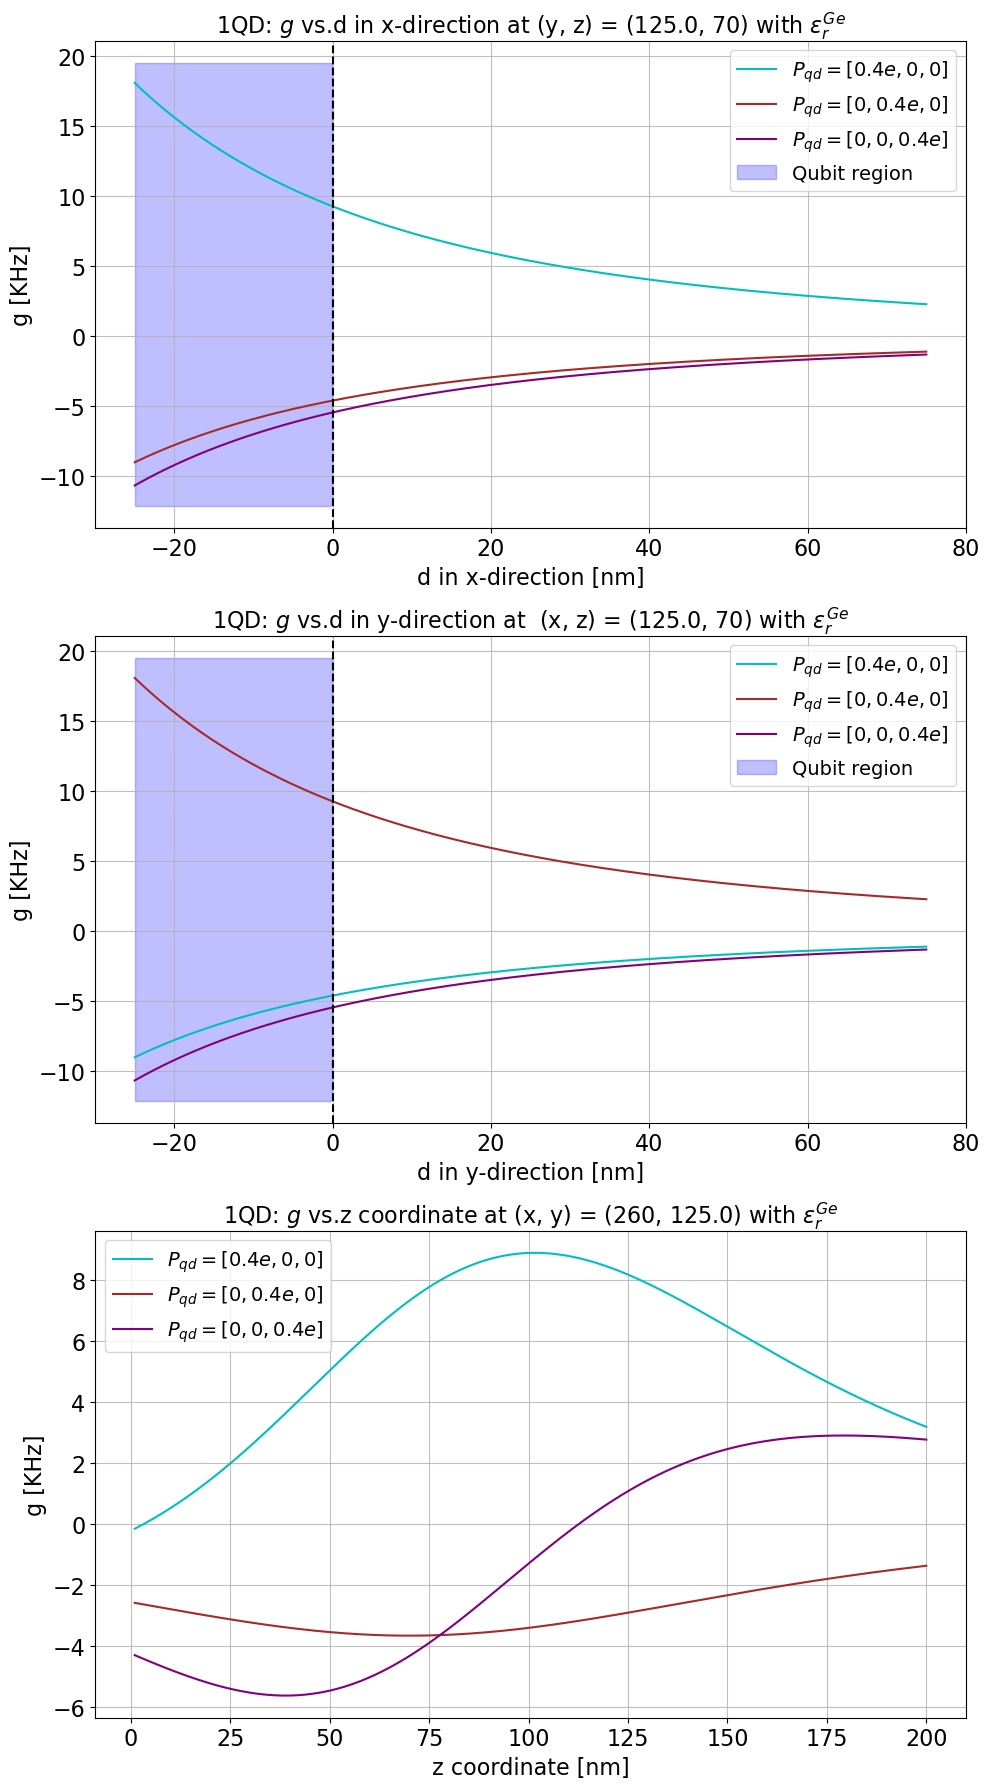

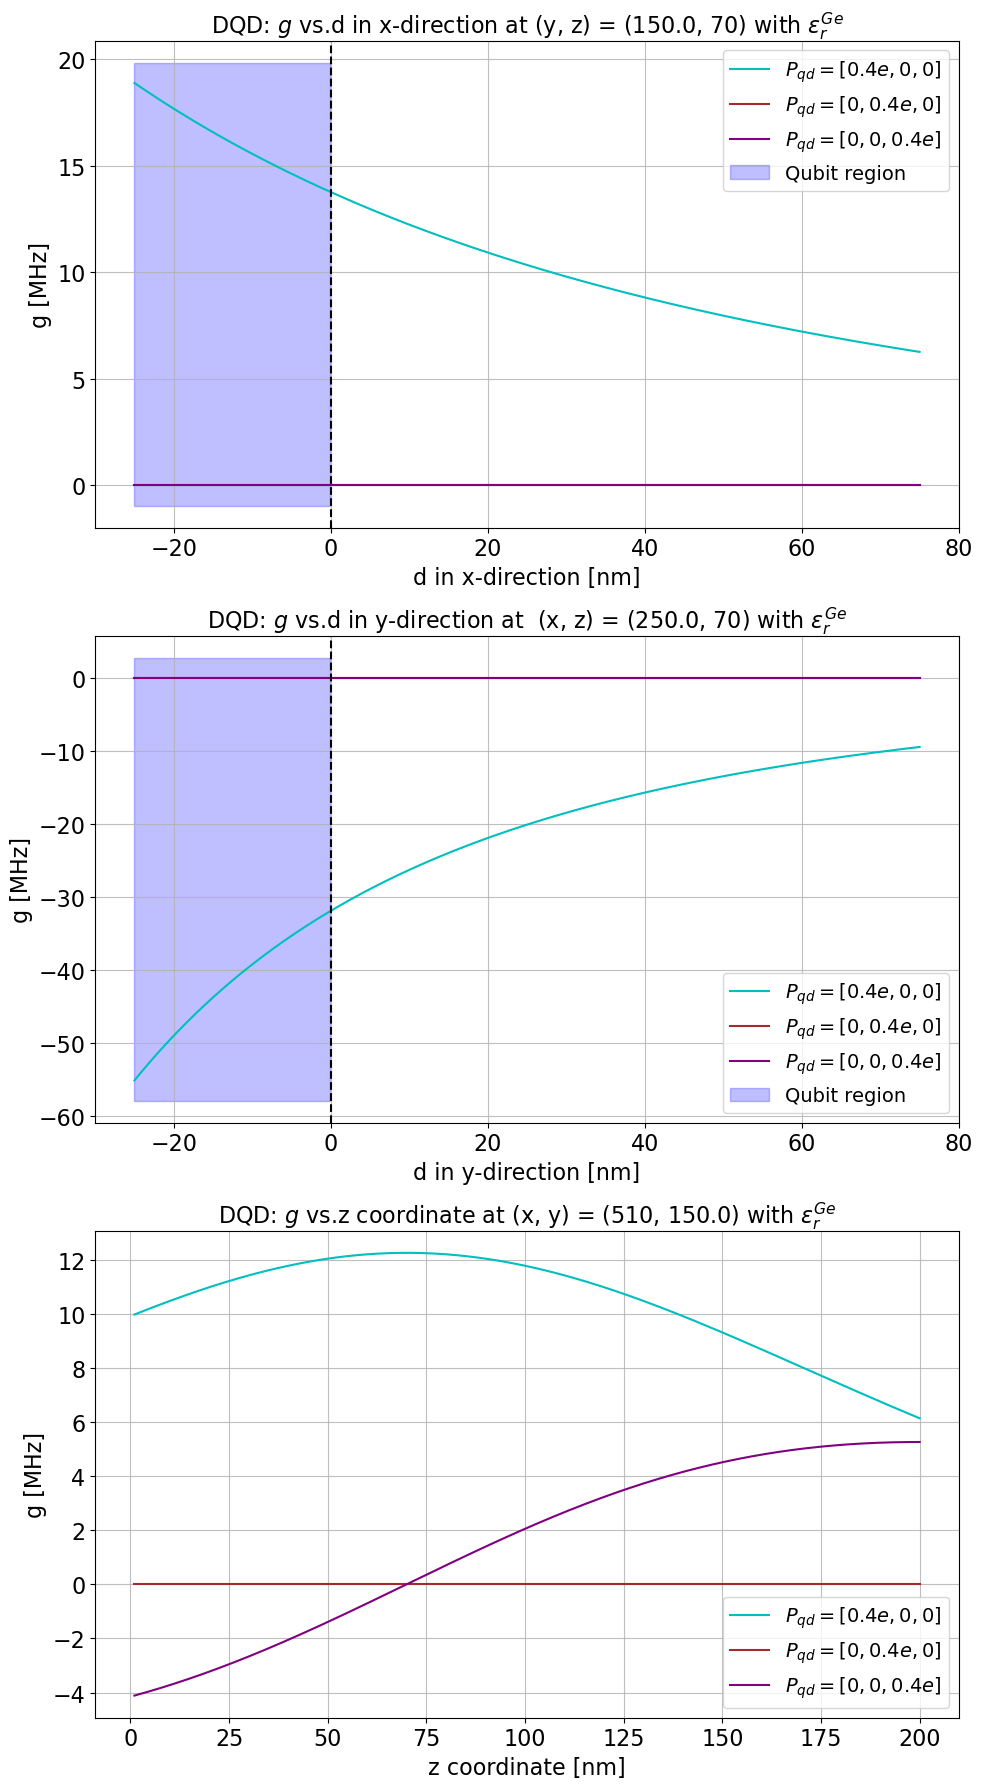

[[[18.897797500392297,
   18.872597640395075,
   18.84744256521332,
   18.82233217540257,
   18.797266371783245,
   18.772245055439807,
   18.747268127719916,
   18.722335490233657,
   18.697447044852677,
   18.672602693709425,
   18.647802339196335,
   18.62304588396493,
   18.598333230925185,
   18.573664283244586,
   18.549038944347384,
   18.524457117913826,
   18.49991870787931,
   18.47542361843364,
   18.450971754020244,
   18.426563019335337,
   18.402197319327186,
   18.37787455919537,
   18.353594644389865,
   18.329357480610486,
   18.305162973805878,
   18.281011030172948,
   18.25690155615602,
   18.23283445844602,
   18.20880964397984,
   18.184827019939487,
   18.160886493751345,
   18.13698797308549,
   18.113131365854812,
   18.08931658021443,
   18.065543524560834,
   18.041812107531154,
   18.018122238002498,
   17.99447382509115,
   17.970866778151827,
   17.947301006777028,
   17.923776420796205,
   17.900292930275125,
   17.876850445515124,
   17.85344887705233,
 

In [47]:
#The same procedure for assuming epsilon in Ge slab, just swapping the compute_coupling function with compute_dielecGe_coupling.
def g_SQD_dielec_plotter(dist_x_ranges, dist_y_ranges, dist_z_ranges, spin_loc, p_val): 
    x_list, y_list, z_list = make_SQD_lists(dist_x_ranges, dist_y_ranges, dist_z_ranges, spin_loc)
    labels = ['d in x-direction', 'd in y-direction', 'z coordinate']
    well_dim_labels = ['Qubit region', 'Qubit region', 'Qubit z-location']
    well_dim = [L_SQD_real, W_SQD_real, z_qubit]

    other_pos = [f'(y, z) = ({x_list[0][1]}, {x_list[0][2]})', f' (x, z) = ({y_list[0][0]}, {y_list[0][2]})', f'(x, y) = ({z_list[0][0]}, {z_list[0][1]})']

    dipoles = [[p_val, 0, 0], [0, p_val, 0], [0, 0, p_val]]
    dipole_labels = ['$P_{qd} = [0.4e,0,0]$', '$P_{qd} = [0,0.4e,0]$', '$P_{qd} = [0,0,0.4e]$']

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))
    fig.subplots_adjust(hspace=0.3, wspace=0.25)
    axes = [ax1, ax2, ax3]

    colors_dielec = ['c', 'brown', 'purple']

    g_collective = []

    for i in range(3):
        g_col_intermediate = []
        for j in range(3):
            dist_list = [x_list, y_list, z_list][i]
            d_dists = make_SQD_dists(dist_x_ranges, dist_y_ranges, dist_z_ranges, spin_loc)[i]
            d_dists_arr = np.array(d_dists)
            g_i_vac = []
            for dist in dist_list:
                g_i_vac.append(compute_dielecGe_coupling(p_emit=dipoles[j], emit_loc=dist, spin_loc=spin_loc)[0] * 1e-3) #in MHz
            axes[i].plot(d_dists, g_i_vac, label=f'{dipole_labels[j]}', color = colors_dielec[j])
            g_col_intermediate.append(g_i_vac)
        g_collective.append(g_col_intermediate)
        if i !=2:
            axes[i].axvline(0, color='black', linestyle='dashed')
            # Shade the region d < 0 (barrier side)
            axes[i].fill_between(d_dists_arr, axes[i].get_ylim()[0], axes[i].get_ylim()[1],
                                 where=(d_dists_arr < 0), alpha=0.25, color='blue', label='Qubit region')
        axes[i].set_xlabel(f'{labels[i]} [nm]', fontsize =16)
        axes[i].set_ylabel('g [KHz]', fontsize =16)
        axes[i].set_title(fr'1QD: $g$ vs.{labels[i]} at {other_pos[i]} with $\varepsilon_r^{{Ge}}$', fontsize = 16)
        axes[i].legend(fontsize=14, loc='best', frameon=True, ncol=1)
        axes[i].tick_params(axis='both', which='major', labelsize=16)
        axes[i].grid(True, alpha=.8)
    #fig.suptitle('Coupling for 1 well as a function of distance from emitter to spin qubit with $\epsilon_{r}^{Ge}=16.0$', fontsize=16)
    plt.tight_layout()
    #plt.savefig('g_1well_dielec.png', dpi=500, bbox_inches='tight')
    plt.show()

    return g_collective

def g_DQD_dielec_plotter(dist_x_ranges, dist_y_ranges, dist_z_ranges, spin_loc, p_val): 
    x_list, y_list, z_list = make_DQD_lists(dist_x_ranges, dist_y_ranges, dist_z_ranges, spin_loc)
    labels = ['d in x-direction', 'd in y-direction', 'z coordinate']
    well_dim_labels = ['Qubit region', 'Qubit region', 'Qubit z-location']
    well_dim = [L_DQD_real, W_DQD_real, z_qubit]

    other_pos = [f'(y, z) = ({x_list[0][1]}, {x_list[0][2]})', f' (x, z) = ({y_list[0][0]}, {y_list[0][2]})', f'(x, y) = ({z_list[0][0]}, {z_list[0][1]})']

    dipoles = [[p_val, 0, 0], [0, p_val, 0], [0, 0, p_val]]
    dipole_labels = ['$P_{qd} = [0.4e,0,0]$', '$P_{qd} = [0,0.4e,0]$', '$P_{qd} = [0,0,0.4e]$']

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))
    fig.subplots_adjust(hspace=0.3, wspace=0.25)
    axes = [ax1, ax2, ax3]

    colors_dielec = ['c', 'brown', 'purple']

    g_collective = []

    for i in range(3):
        g_col_intermediate = []
        for j in range(3):
            dist_list = [x_list, y_list, z_list][i]
            d_dists = make_DQD_dists(dist_x_ranges, dist_y_ranges, dist_z_ranges, spin_loc)[i]
            d_dists_arr = np.array(d_dists)

            g_i_vac = []
            for dist in dist_list:
                g_i_vac.append(compute_dielecGe_coupling(p_emit=dipoles[j], emit_loc=dist, spin_loc=spin_loc)[1] * 1e-6) #in MHz
            axes[i].plot(d_dists, g_i_vac, label=f'{dipole_labels[j]}', color = colors_dielec[j])
            g_col_intermediate.append(g_i_vac)
        g_collective.append(g_col_intermediate)
        if i !=2:
            axes[i].axvline(0, color='black', linestyle='dashed')
            # Shade the region d < 0 (barrier side)
            axes[i].fill_between(d_dists_arr, axes[i].get_ylim()[0], axes[i].get_ylim()[1],
                                 where=(d_dists_arr < 0), alpha=0.25, color='blue', label='Qubit region')
        axes[i].set_xlabel(f'{labels[i]} [nm]', fontsize =16)
        axes[i].set_ylabel('g [MHz]', fontsize =16)
        axes[i].set_title(fr'DQD: $g$ vs.{labels[i]} at {other_pos[i]} with $\varepsilon_r^{{Ge}}$', fontsize = 16)
        axes[i].legend(fontsize=14, loc='best', frameon=True, ncol=1)
        axes[i].tick_params(axis='both', which='major', labelsize=16)
        axes[i].grid(True, alpha=.8)
    #fig.suptitle('Coupling for 2 well as a function of distance from emitter to spin qubit with $\epsilon_{r}^{Ge}=16.0$', fontsize=16)
    plt.tight_layout()
    #plt.savefig('g_DQD_dielec.png', dpi=500, bbox_inches='tight')
    plt.show()

    return g_collective 

#g_SQD_dielec_plotter(dist_xyranges_1well, dist_zranges, spin_loc = spin_qubit_loc_SQD, p_val = p_val)
#g_DQD_dielec_plotter(dist_xyranges_2well, dist_zranges, spin_loc = spin_qubit_loc_DQD, p_val = p_val)

g_SQD_dielec_plotter(dist_xranges_SQD, dist_yranges_SQD, dist_zranges, spin_loc = spin_qubit_loc_SQD, p_val = p_val)
g_DQD_dielec_plotter(dist_xranges_DQD, dist_yranges_DQD, dist_zranges, spin_loc = spin_qubit_loc_DQD, p_val = p_val)

#### Now we are preparing plotting the Raman scattering probability. First we retrieve the coupling data from above. 

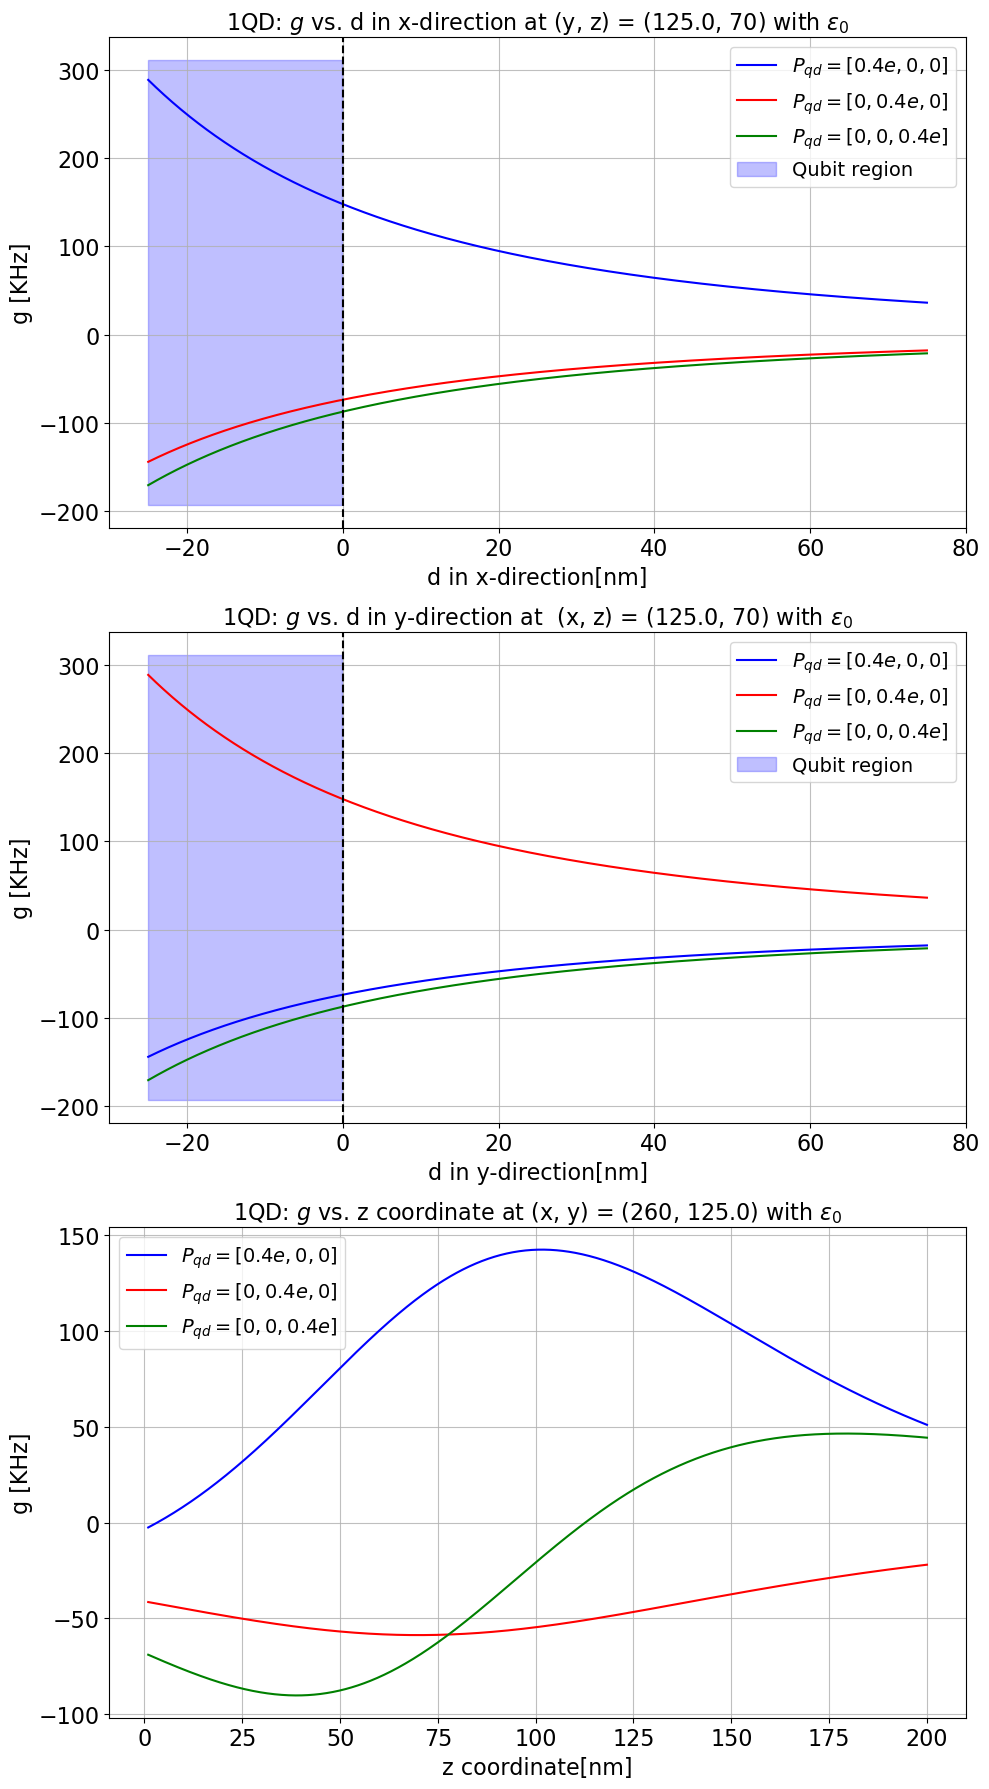

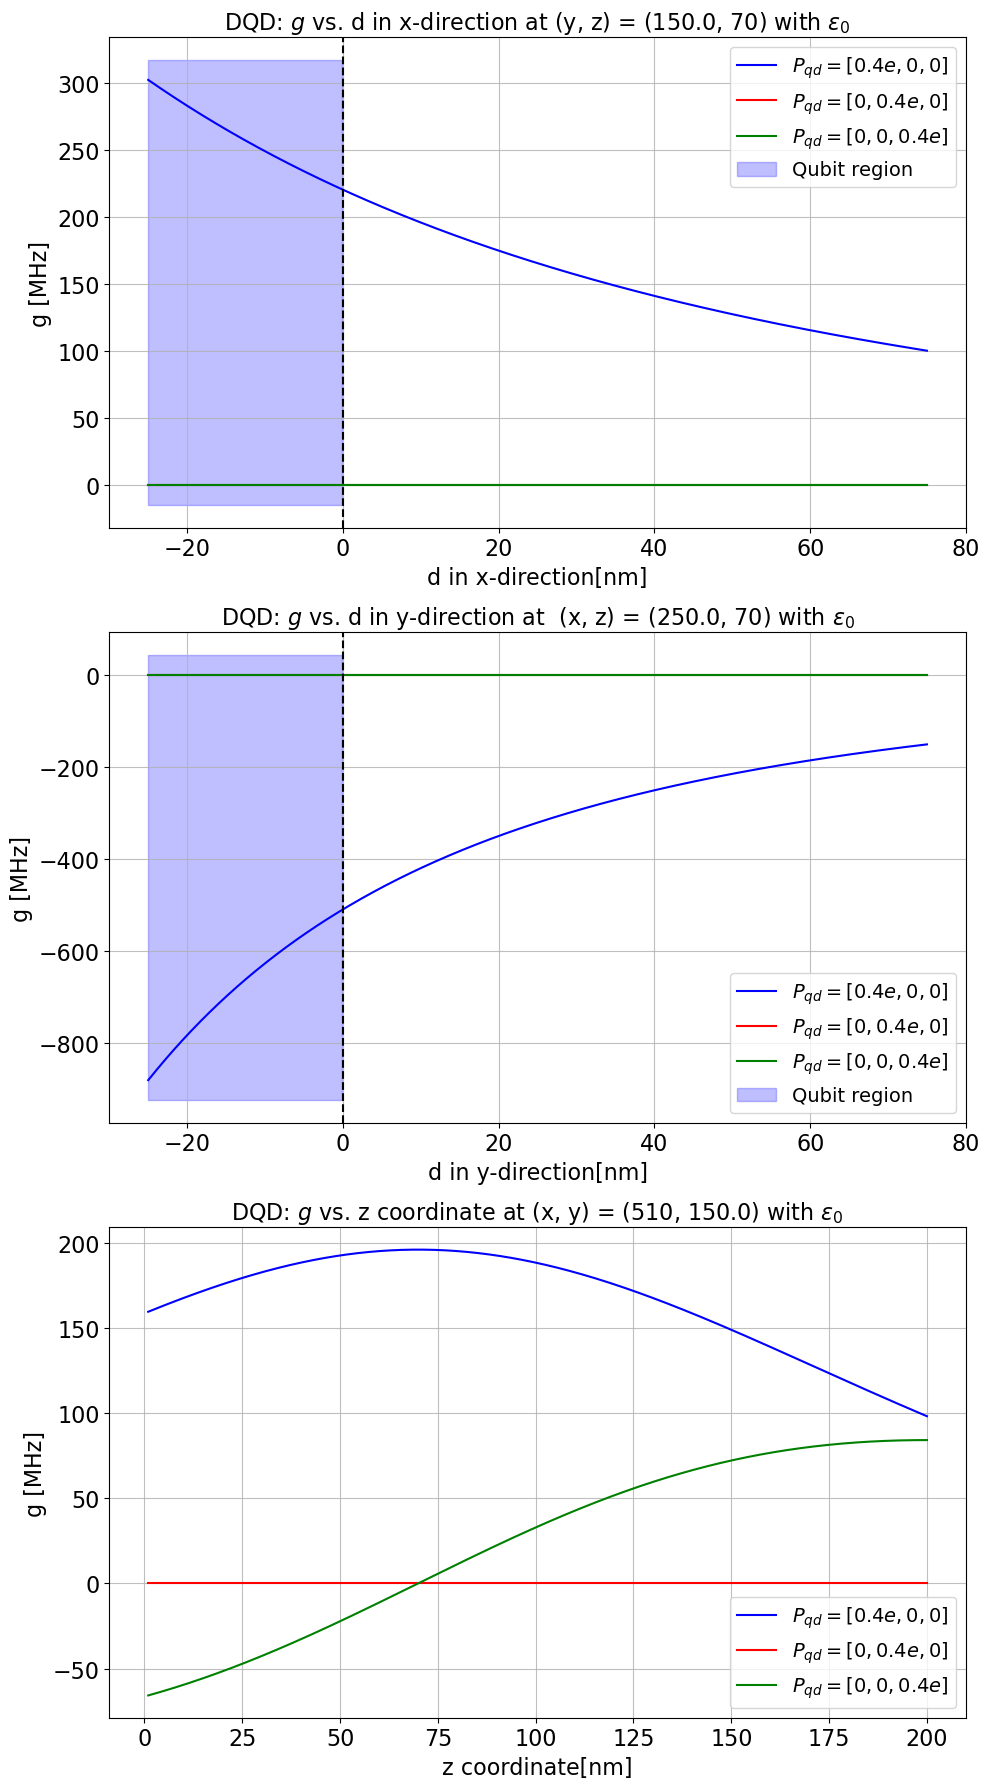

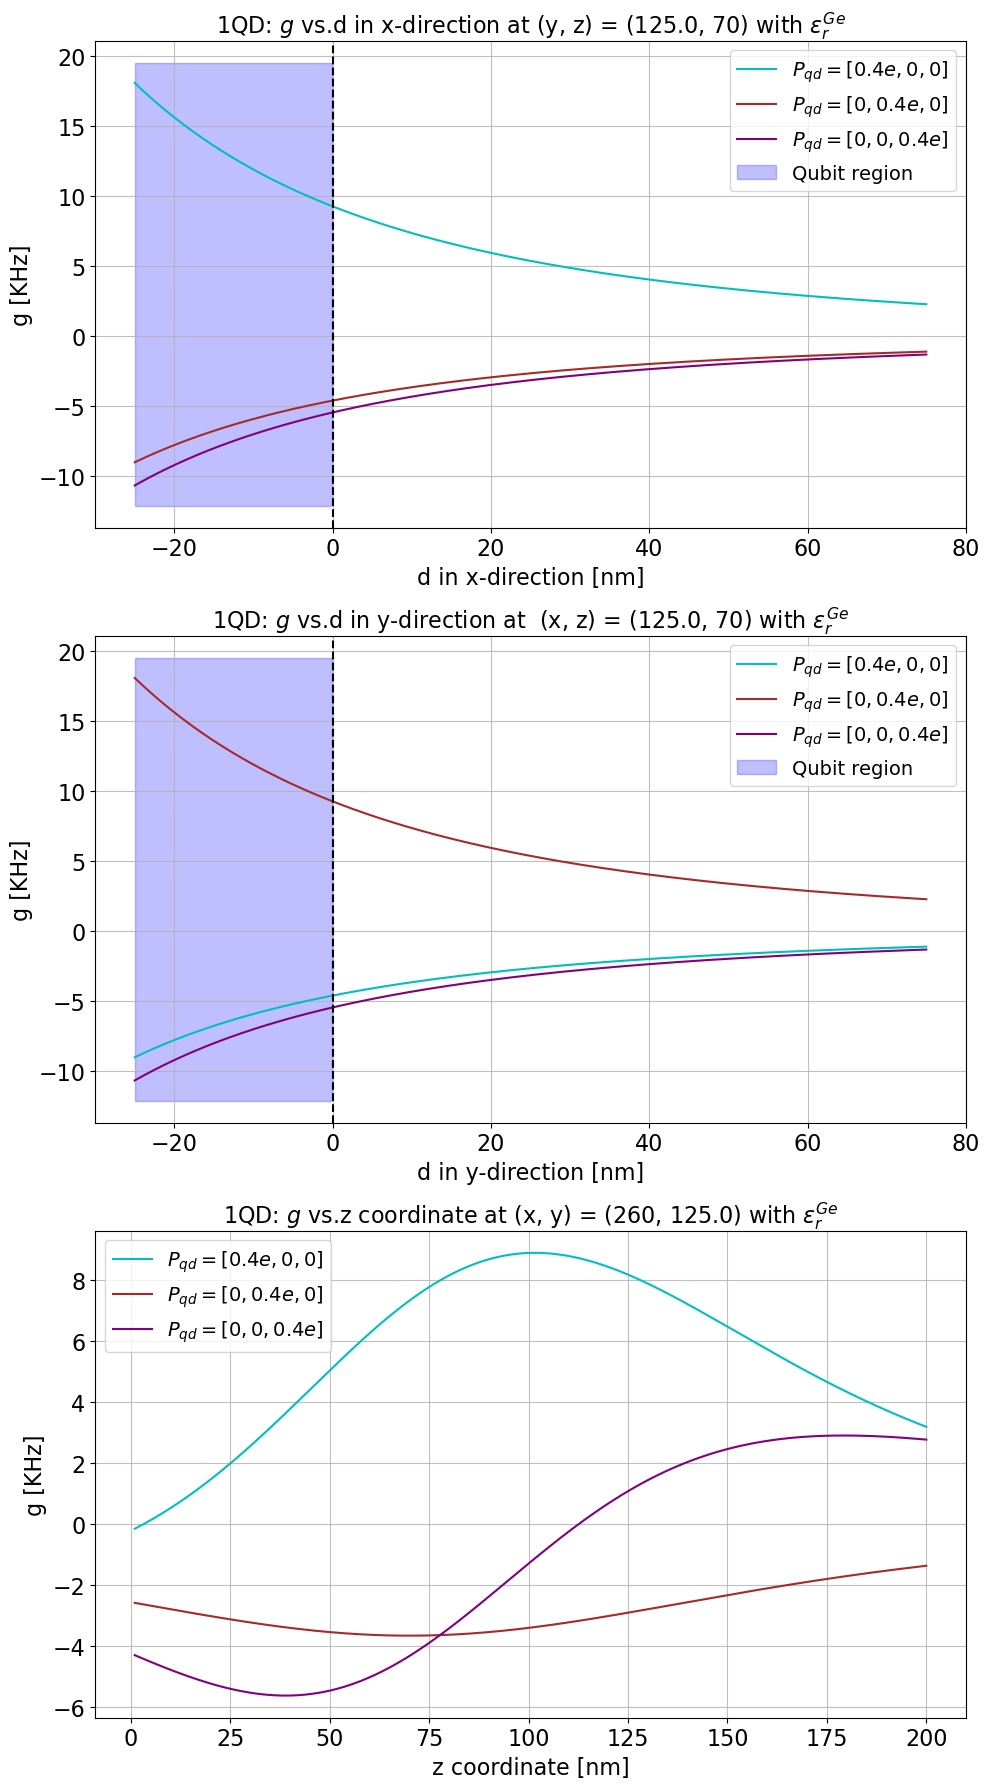

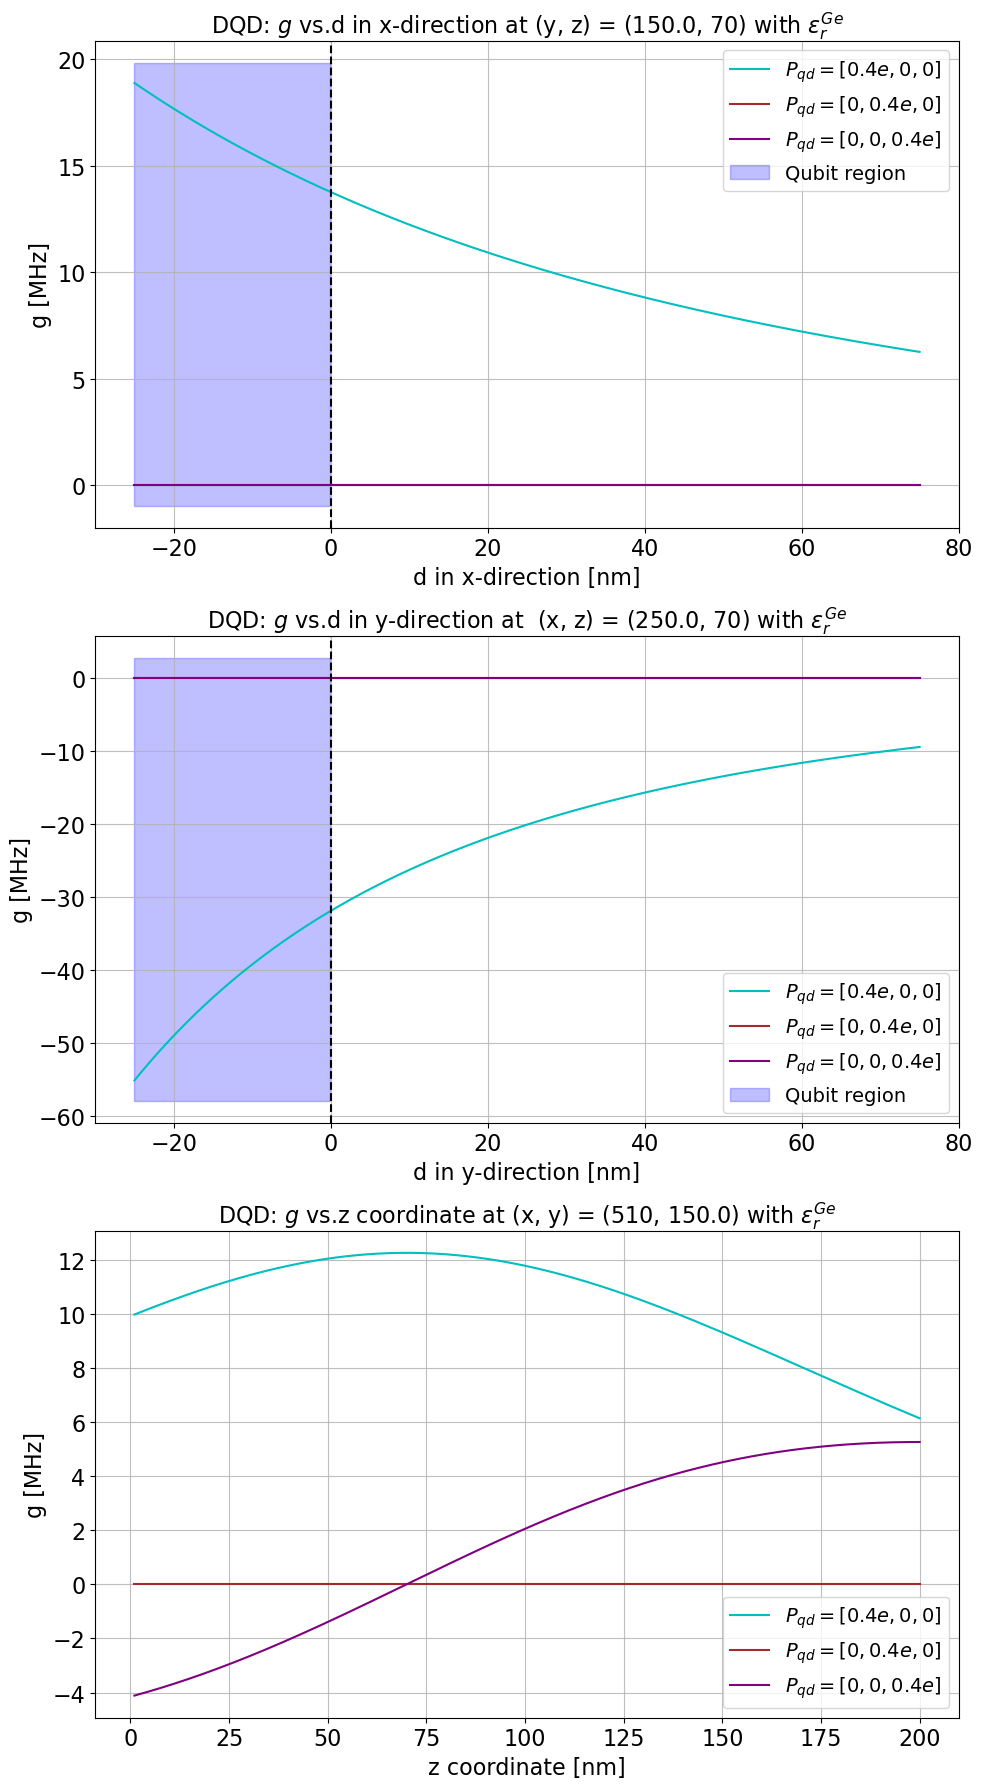

In [48]:
g_SQD_vac = g_SQD_plotter(dist_xranges_SQD, dist_yranges_SQD, dist_zranges, spin_loc = spin_qubit_loc_SQD, p_val = p_val)
g_DQD_vac = g_DQD_plotter(dist_xranges_DQD, dist_yranges_DQD, dist_zranges, spin_loc = spin_qubit_loc_DQD, p_val = p_val)
g_1well_dielec = g_SQD_dielec_plotter(dist_xranges_SQD, dist_yranges_SQD, dist_zranges, spin_loc = spin_qubit_loc_SQD, p_val = p_val)
g_DQD_dielec = g_DQD_dielec_plotter(dist_xranges_DQD, dist_yranges_DQD, dist_zranges, spin_loc = spin_qubit_loc_DQD, p_val = p_val)

#### For the project, we made a special plot for DQD setup with a dipole in the x-direction. This is Fig. (4.3a). 

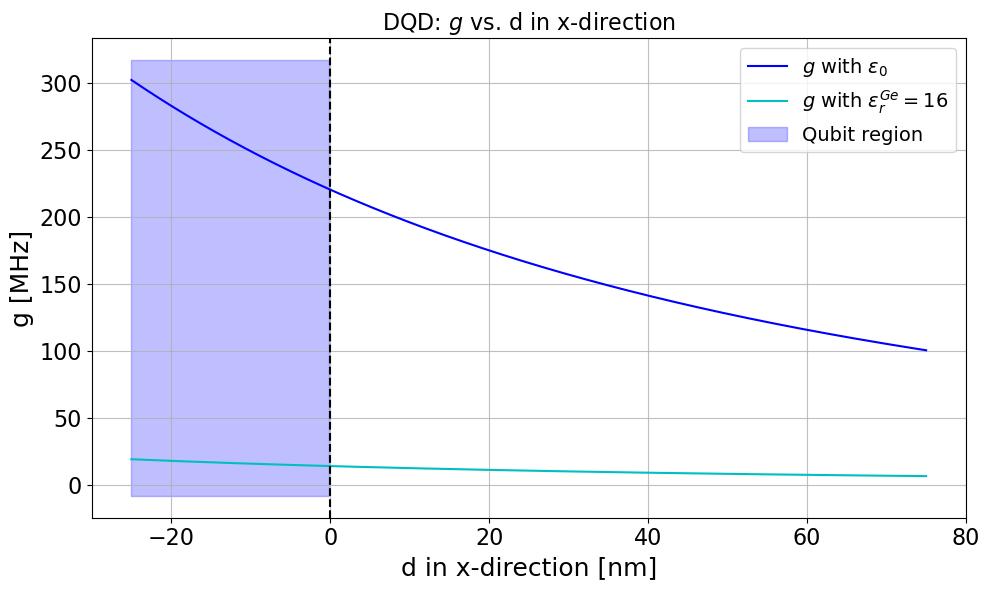

In [49]:
def plot_g_vac_dielec_x_direction(dist_xranges_DQD, dist_yranges_DQD, dist_zranges, spin_loc_2well, p_val, g_DQD_vac, g_DQD_dielec):
    # Only x-direction, only x-dipole
    d_x = make_DQD_dists(dist_xranges_DQD, dist_yranges_DQD, dist_zranges, spin_loc_2well)[0] #[0] gives the x-distances
    d_x = np.array(d_x)
    plt.figure(figsize=(10, 6))
    plt.plot(d_x, g_DQD_vac[0][0], color='b', linestyle='-', label='$g$ with $\\varepsilon_0$')
    plt.plot(d_x, g_DQD_dielec[0][0], color='c', linestyle='-', label='$g$ with $\\varepsilon_r^{Ge}=16$')
    plt.axvline(0, color='black', linestyle='dashed')
    plt.fill_between(d_x, plt.ylim()[0], plt.ylim()[1], where=(d_x < 0), alpha=0.25, color='blue', label='Qubit region')
    plt.xlabel('d in x-direction [nm]', fontsize=18)
    plt.ylabel('g [MHz]', fontsize=18)
    plt.title('DQD: $g$ vs. d in x-direction', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(fontsize=14, frameon=True)
    plt.grid(True, alpha=.8)
    plt.tight_layout()
    #plt.savefig('g_DQD_vac_dielec_x_direction.png', dpi=500, bbox_inches='tight')
    plt.show()

plot_g_vac_dielec_x_direction(dist_xranges_DQD, dist_yranges_DQD, dist_zranges, spin_qubit_loc_DQD, p_val, g_DQD_vac, g_DQD_dielec)

### Then we compute $P_r$ using Eq. 2.9 and Eq. 2.10. Here we make Fig. (4.1c, 4.1d) and Fig. (4.2c, 4.2d), and the figures in Appendix B. 

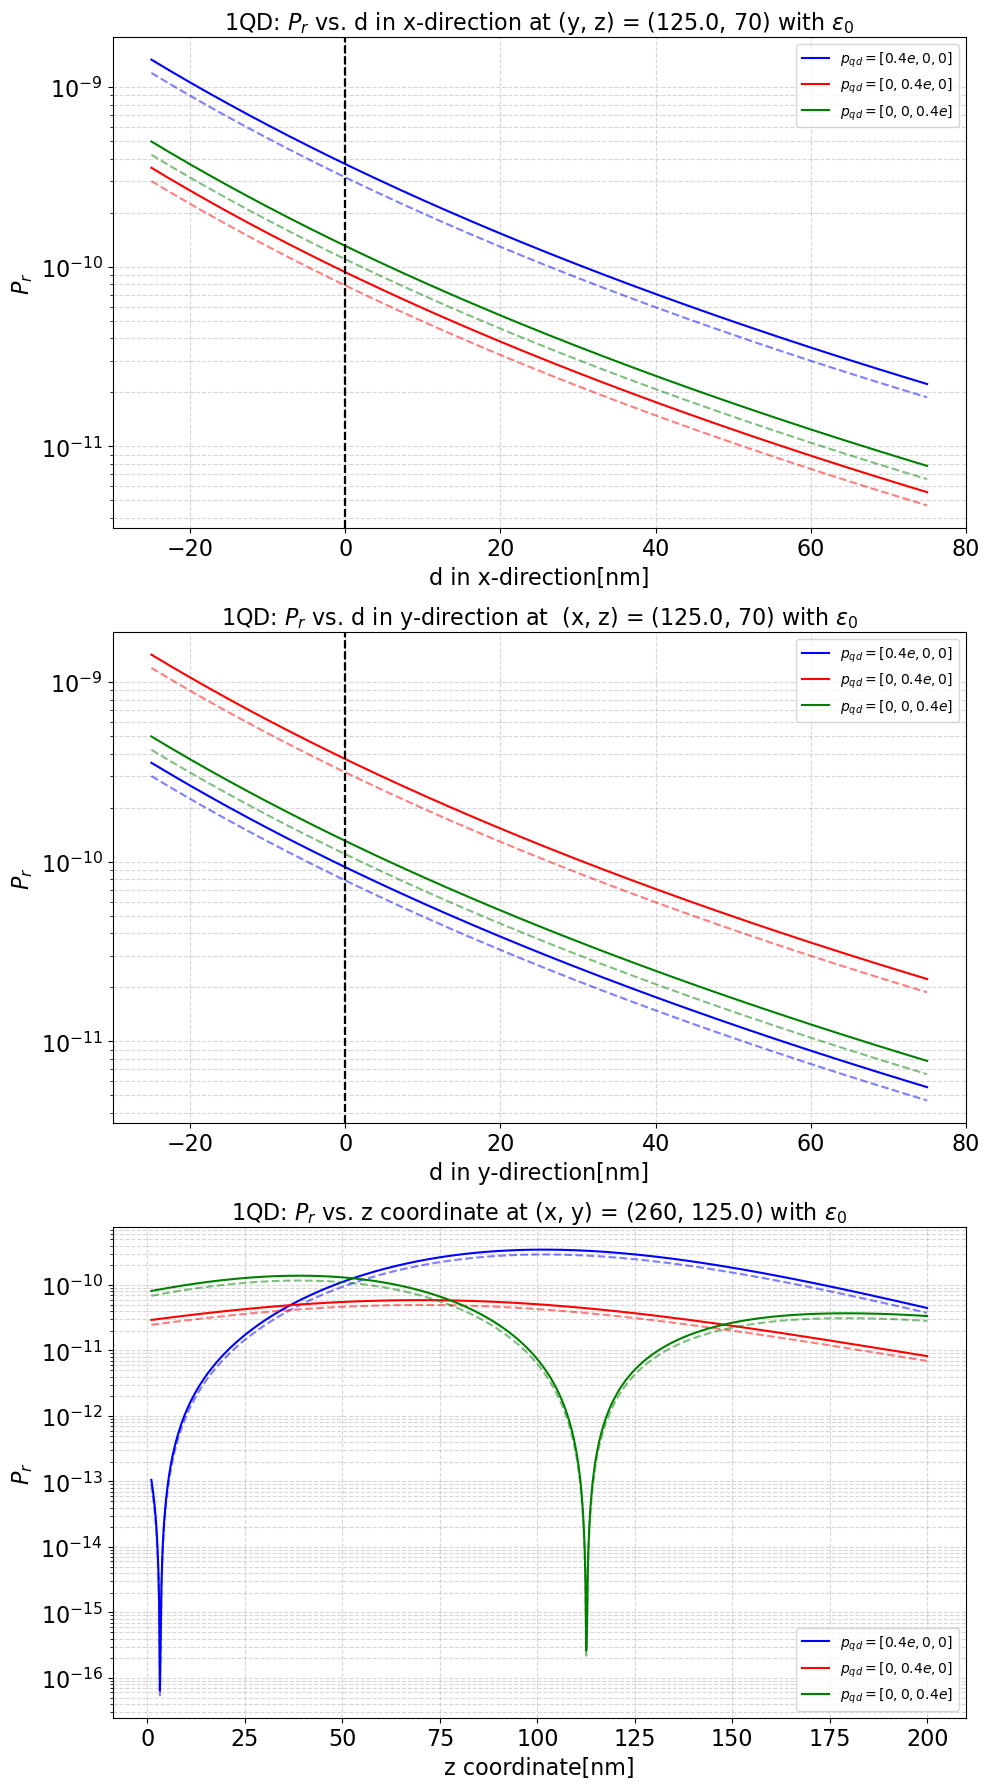

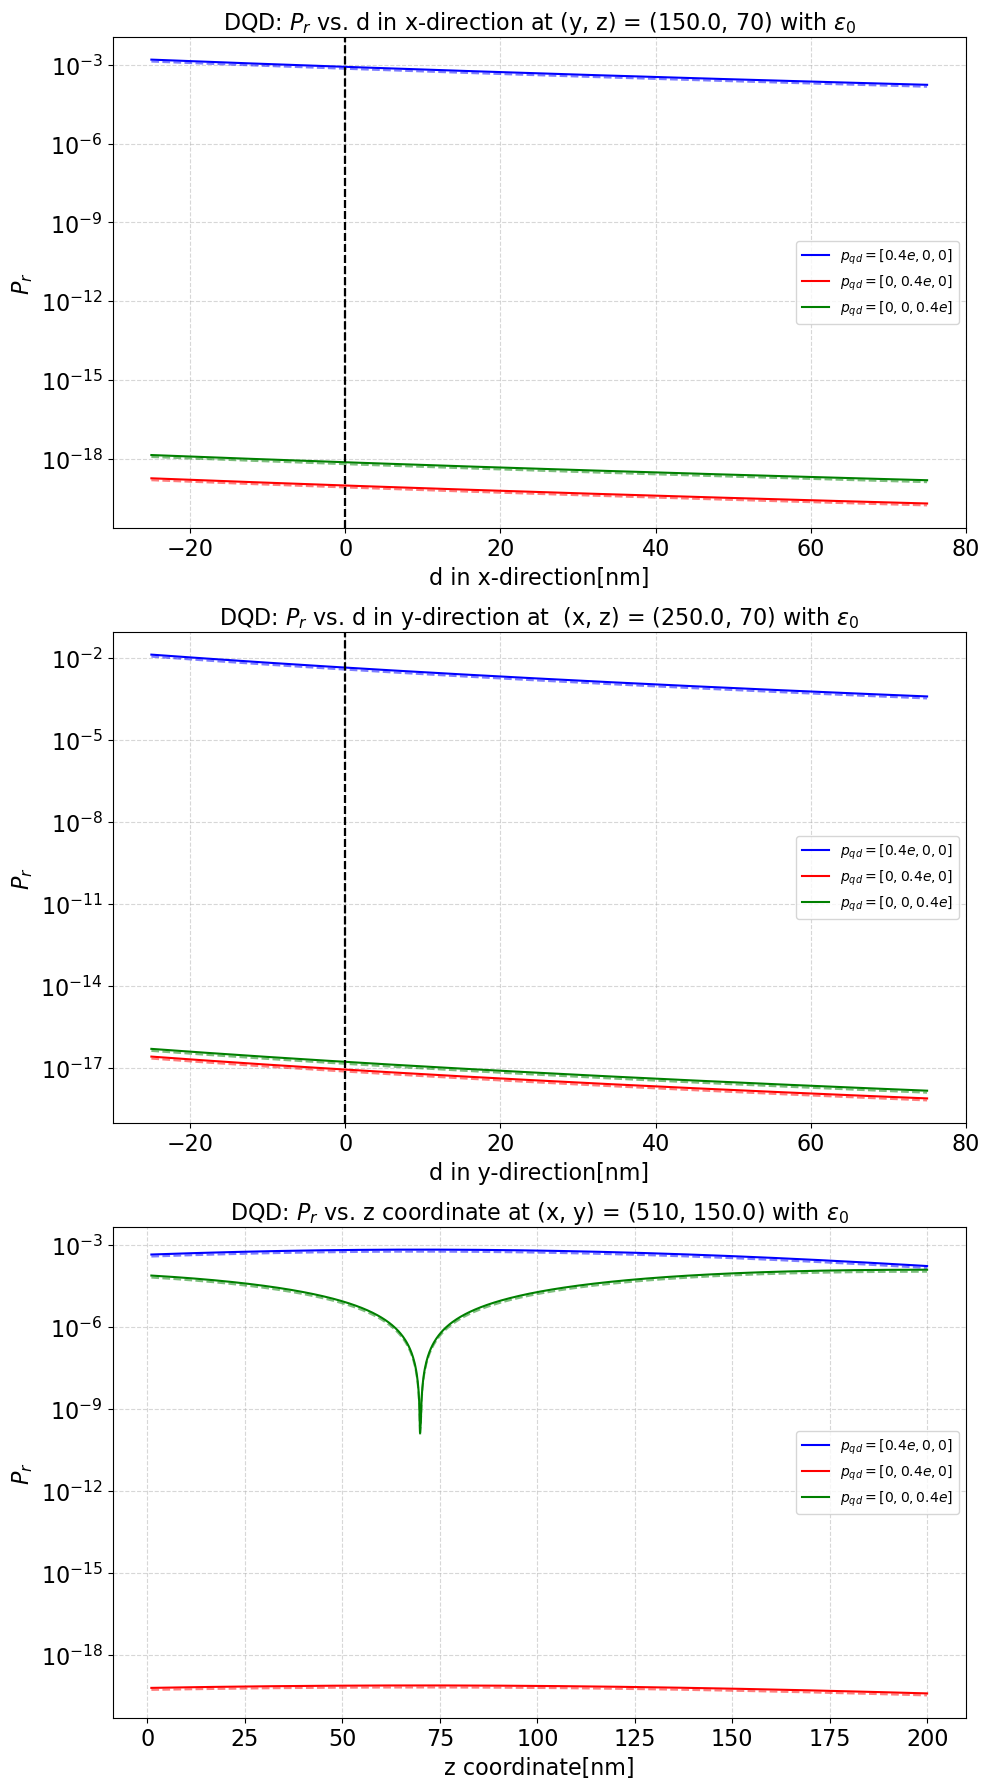

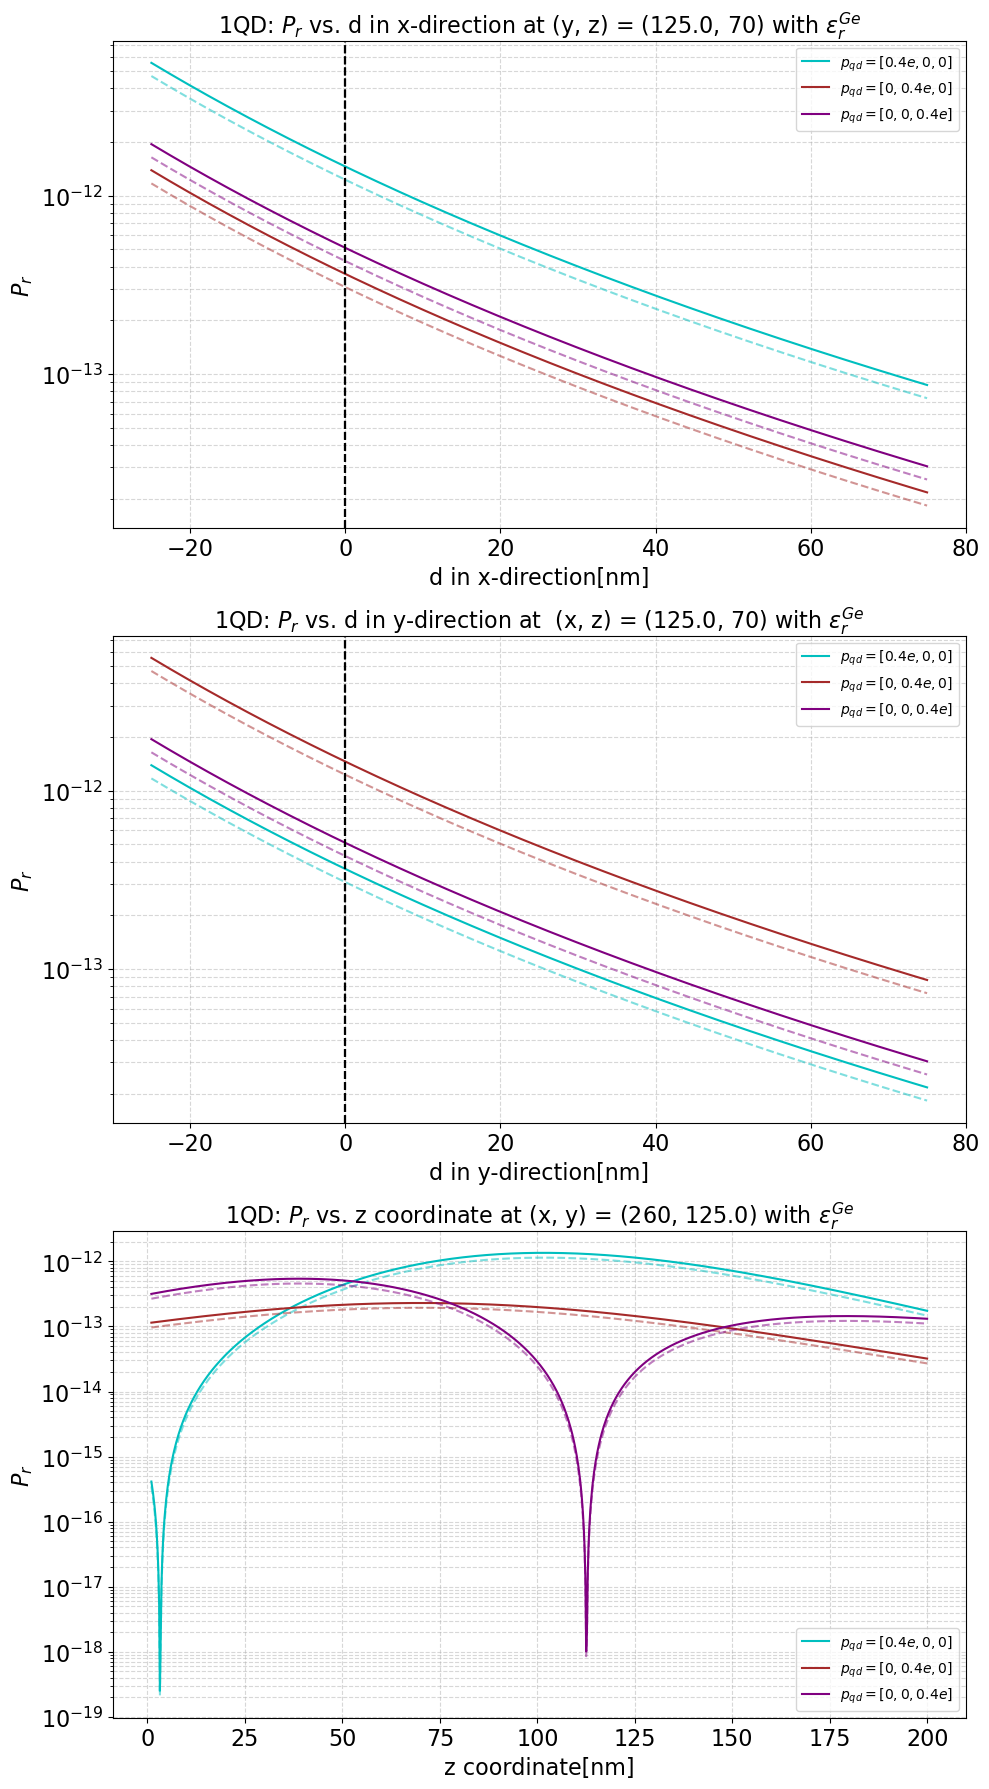

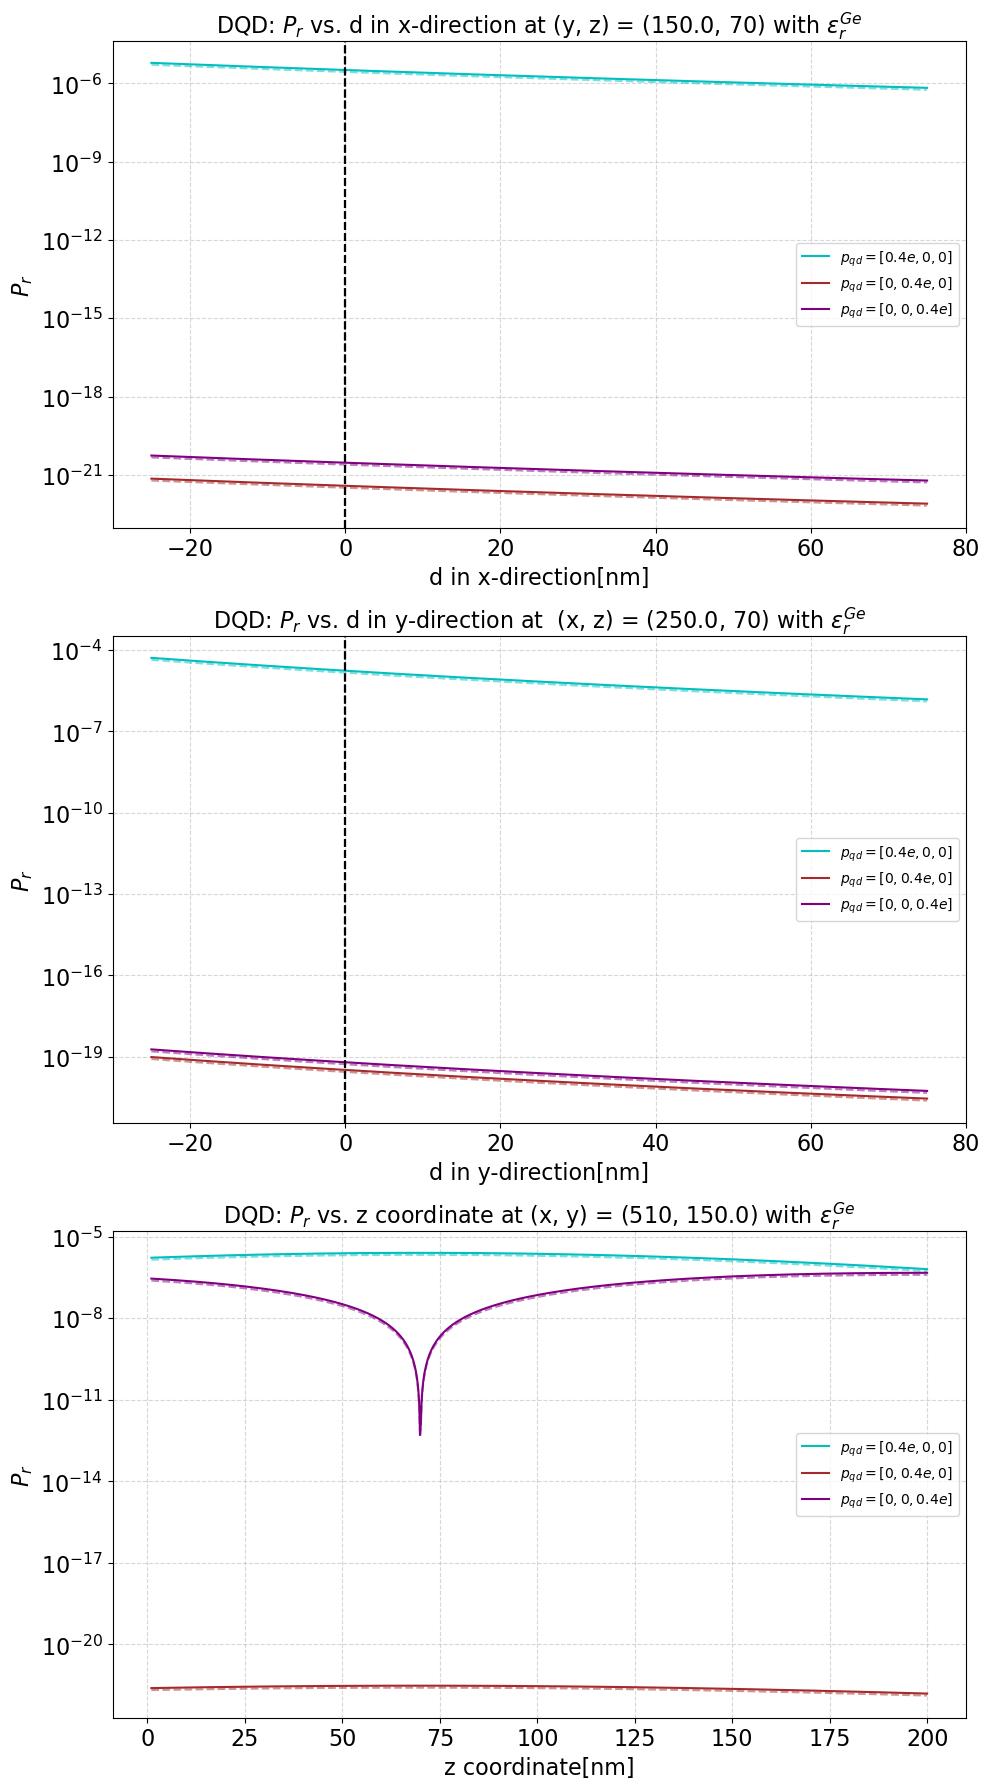

In [ ]:
#Finding the Raman probability. Different beta values are used to see the effect of waveguide coupling efficiency on the Raman probability. 
beta_1 = 0.9
beta_2 = 0.98
beta_avg = (beta_1 + beta_2)/2

betas = [beta_1, beta_2]
alpha = [0.5, 1] #To distinguish the two beta values in the plots, we use alpha to set the transparency of the lines.

# Function to compute the Raman probability for SQD.
def compute_raman_SQD(dist_xranges, dist_yranges, dist_zranges, spin_loc, g_1well_data, betas, alpha, type):
    label = 'vacuum' if type == 'vacuum' else '$\epsilon_{r}^{Ge}=16.0$' #In this function we incorporate both the vacuum and the Ge slab case, and by calling the function with either 'vac' or 'dielec' we can plot both cases.
    #Again color consistency is used for the plots.
    if type == 'vac':
        colors_vac = ['b', 'r', 'g']
    else:
        colors_vac = ['c', 'brown', 'purple']
    
    #Havung adjusted the energy-gap to match target frequency, we can just use the constant, so we don't have to calculate it again.
    qubit_freq = target_freq*1e-6 #in Mhz
    
    #Labeling. 
    labels = ['d in x-direction', 'd in y-direction', 'z coordinate']
    dipole_labels = ['$p_{qd} = [0.4e,0,0]$', '$p_{qd} = [0,0.4e,0]$', '$p_{qd} = [0,0,0.4e]$']


    x_list, y_list, z_list = make_SQD_lists(dist_xranges, dist_yranges, dist_zranges, spin_loc)
    other_pos = [f'(y, z) = ({x_list[0][1]}, {x_list[0][2]})', f' (x, z) = ({y_list[0][0]}, {y_list[0][2]})', f'(x, y) = ({z_list[0][0]}, {z_list[0][1]})']

    dists = make_SQD_dists(dist_xranges, dist_yranges, dist_zranges, spin_loc) #Distances. 
    d_dists_arr = np.array(dists)  # Use the x-dist for the fill_between
    g = [g_1well_data[0], g_1well_data[1], g_1well_data[2]] # Collecting the g values for each dipole orientation.
    g= np.array(g)*1e-3  # Convert to numpy array for easier indexing and multiply by 1e-3 to convert to MHz, so the frequency gap and g are the same units.
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))
    fig.subplots_adjust(hspace=0.3, wspace=0.25)
    axes = [ax1, ax2, ax3]
    #Here we plot the Raman probability for each dipole orientation and distance.
    for i in range(3):
        g_i = g[i]
        dist = dists[i] 
        for j in range(3):
            p_r_beta1 = []
            p_r_beta2 = []
            g_ij = g_i[j]
            for k in range(len(g_ij)): #Using Eq. 2.9
                if g_ij[k] > qubit_freq:
                    p_r_beta1.append((betas[0])**2)
                    p_r_beta2.append((betas[1])**2)
                else: #Using Eq. 2.10
                    p_r_beta1.append((betas[0])**2 * ((g_ij[k])/(qubit_freq))**2)
                    p_r_beta2.append((betas[1])**2 * ((g_ij[k])/(qubit_freq))**2)
            axes[i].plot(dist, p_r_beta1, linestyle = '--', label=f'{dipole_labels[j]}', alpha = alpha[0], color = colors_vac[j])#Then we plot. 
            axes[i].plot(dist, p_r_beta2, label=f'{dipole_labels[j]}', alpha = alpha[1], color = colors_vac[j])
            if i !=2: #Marking qubit-territory. 
                axes[i].axvline(0, color='black', linestyle='dashed')
        axes[i].set_xlabel(f'{labels[i]}[nm]', fontsize = 16)
        axes[i].set_ylabel('$P_r$', fontsize = 16)
        if type == 'vac':  #Titleling.
            axes[i].set_title(fr'1QD: $P_r$ vs. {labels[i]} at {other_pos[i]} with $\varepsilon_0$', fontsize = 16)
        else:
            axes[i].set_title(fr'1QD: $P_r$ vs. {labels[i]} at {other_pos[i]} with $\varepsilon_r^{{Ge}}$', fontsize = 16)
        axes[i].set_yscale('log')
        axes[i].grid(True, which='both', linestyle='--', alpha=0.5)
        axes[i].legend(fontsize=20, loc='best', frameon=True, ncol=1)
        axes[i].tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), fontsize=10, loc='best', frameon=True, ncol=1)
    #plt.savefig(f'raman_1well_{type}.png', dpi=500)
    plt.show()

#Same for DQD. 
def compute_raman_DQD(dist_xranges, dist_yranges, dist_zranges, spin_loc, g_2well_data, betas, alpha, type):
    label = 'vacuum' if type == 'vac' else '$\epsilon_{r}^{Ge}=16.0$'
    if type == 'vac':
        colors_vac = ['b', 'r', 'g']
    else:
        colors_vac = ['c', 'brown', 'purple']

    qubit_freq = target_freq*1e-6 #in Mhz
    beta_list = [betas[0], betas[1]]
    labels = ['d in x-direction', 'd in y-direction', 'z coordinate']
    beta_labels = [f'$\\beta_{j} = {beta_list[j]} $' for j in range(0, 2)]
    alpha_labels = [f'$\\alpha_{i}$' for i in range(1, len(alpha)+1)]

    well_dim_labels = ['Qubit structure x cutoff', 'Qubit structure y cutoff', 'Qubit z-location']
    dipole_labels = ['$p_{qd} = [0.4e,0,0]$', '$p_{qd} = [0,0.4e,0]$', '$p_{qd} = [0,0,0.4e]$']


    x_list, y_list, z_list = make_DQD_lists(dist_xranges, dist_yranges, dist_zranges, spin_loc)
    other_pos = [f'(y, z) = ({x_list[0][1]}, {x_list[0][2]})', f' (x, z) = ({y_list[0][0]}, {y_list[0][2]})', f'(x, y) = ({z_list[0][0]}, {z_list[0][1]})']

    dists = make_DQD_dists(dist_xranges, dist_yranges, dist_zranges, spin_loc)
    d_dists_arr = np.array(dists)  # Use the x-dist for the fill_between
    g = [g_2well_data[0], g_2well_data[1], g_2well_data[2]]

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))
    fig.subplots_adjust(hspace=0.3, wspace=0.25)
    axes = [ax1, ax2, ax3]

    for i in range(3):
        g_i = g[i]
        dist = dists[i] 
        for j in range(3):
            p_r_beta1 = []
            p_r_beta2 = []
            g_ij = g_i[j]
            for k in range(len(g_ij)): 
                if g_ij[k] >= qubit_freq:
                    p_r_beta1.append((betas[0])**2)
                    p_r_beta2.append((betas[1])**2)
                elif g_ij[k] < qubit_freq: 
                    p_r_beta1.append(((betas[0])**2) * ((g_ij[k])/(qubit_freq))**2)
                    p_r_beta2.append(((betas[1])**2) * ((g_ij[k])/(qubit_freq))**2)
            axes[i].plot(dist, p_r_beta1, linestyle = '--', label=f'{dipole_labels[j]}', alpha = alpha[0], color = colors_vac[j])
            axes[i].plot(dist, p_r_beta2, label=f'{dipole_labels[j]}', alpha = alpha[1], color = colors_vac[j])
            if i !=2:
                axes[i].axvline(0, color='black', linestyle='dashed')
        axes[i].set_xlabel(f'{labels[i]}[nm]', fontsize = 16)
        axes[i].set_ylabel('$P_r$', fontsize = 16)
        if type == 'vac': 
            axes[i].set_title(fr'DQD: $P_r$ vs. {labels[i]} at {other_pos[i]} with $\varepsilon_0$', fontsize = 16)
        else:
            axes[i].set_title(fr'DQD: $P_r$ vs. {labels[i]} at {other_pos[i]} with $\varepsilon_r^{{Ge}}$', fontsize = 16)
        axes[i].set_yscale('log')
        axes[i].grid(True, which='both', linestyle='--', alpha=0.5)
        axes[i].legend(fontsize=20, loc='best', frameon=True, ncol=1)
        axes[i].tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), fontsize=10, loc='best', frameon=True, ncol=1)
    #plt.savefig(f'raman_2well_{type}.png', dpi=500)
    plt.show()
        

#Plot for all cases. 
compute_raman_SQD(dist_xranges_SQD, dist_yranges_SQD, dist_zranges, spin_loc=spin_qubit_loc_SQD, g_1well_data=g_SQD_vac, betas=betas, alpha = alpha, type = 'vac')
compute_raman_DQD(dist_xranges_DQD, dist_yranges_DQD, dist_zranges, spin_loc=spin_qubit_loc_DQD, g_2well_data=g_DQD_vac, betas=betas, alpha = alpha, type = 'vac')
compute_raman_SQD(dist_xranges_SQD, dist_yranges_SQD, dist_zranges, spin_loc=spin_qubit_loc_SQD, g_1well_data=g_1well_dielec, betas=betas, alpha = alpha, type = 'dielec')
compute_raman_DQD(dist_xranges_DQD, dist_yranges_DQD, dist_zranges, spin_loc=spin_qubit_loc_DQD, g_2well_data=g_DQD_dielec, betas=betas, alpha = alpha, type = 'dielec')
#How do I normalize? 

#### We are again making a special plot for DQD $P_r$, since the above plots are cluttered. Here we make Fig. (4.3b). 

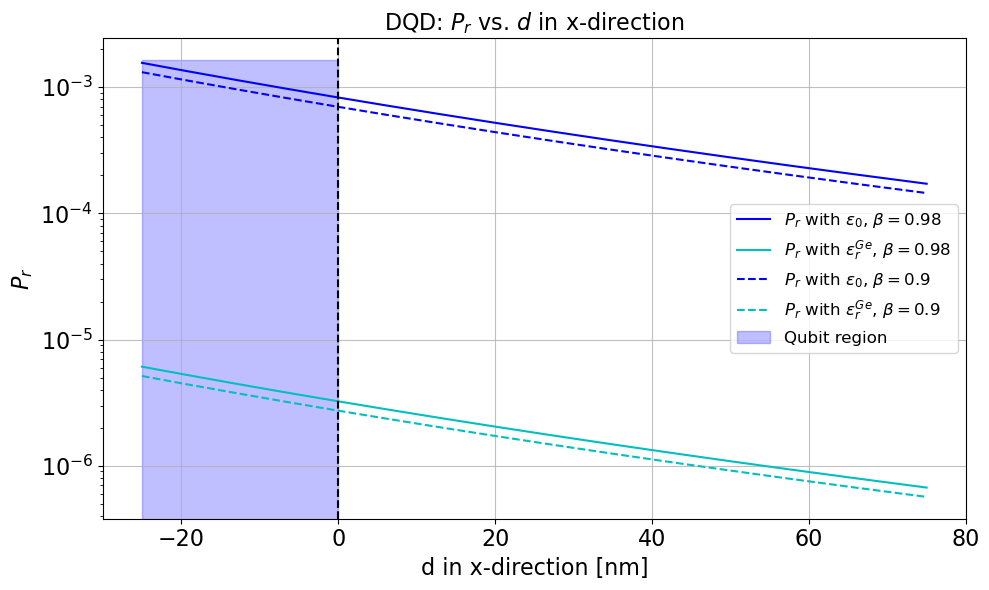

In [ ]:
def plot_pr_vs_dx_2qd_both_betas(g_DQD_vac, g_DQD_dielec, dist_xranges_DQD, spin_qubit_loc_DQD, p_val, betas):
    d_x = make_DQD_dists(dist_xranges_DQD, dist_yranges_DQD, dist_zranges, spin_qubit_loc_DQD)[0]
    d_x = np.array(d_x)
    g_vac = np.array(g_DQD_vac[0][0])  #x-dipole, x-direction
    g_dielec = np.array(g_DQD_dielec[0][0])  #x-dipole, x-direction

    qubit_freq = target_freq * 1e-6  # in MHz

    plt.figure(figsize=(10, 6))
    # Plot beta=0.98 (solid) first, then beta=0.9 (dashed)
    linestyles = ['-', '--']
    beta_labels = [r'$\beta=0.98$', r'$\beta=0.9$']
    betas_plot = [0.98, 0.9]
    for i, beta in enumerate(betas_plot):
        pr_vac = np.where(g_vac > qubit_freq, beta**2, (beta**2) * (g_vac / qubit_freq)**2) #Using np.where here to calculate P_r. In the above I used for-loops, since the unpacking was larger and I'm more comfortable using those.  
        pr_dielec = np.where(g_dielec > qubit_freq, beta**2, (beta**2) * (g_dielec / qubit_freq)**2)
        plt.plot(d_x, pr_vac, color='b', linestyle=linestyles[i], label=f'$P_r$ with $\epsilon_0$, {beta_labels[i]}')
        plt.plot(d_x, pr_dielec, color='c', linestyle=linestyles[i], label=f'$P_r$ with $\epsilon_r^{{Ge}}$, {beta_labels[i]}')

    plt.axvline(0, color='black', linestyle='dashed')
    plt.fill_between(d_x, plt.ylim()[0], plt.ylim()[1], where=(d_x < 0), alpha=0.25, color='blue', label='Qubit region')
    plt.xlabel('d in x-direction [nm]', fontsize=16)
    plt.ylabel(r'$P_r$', fontsize=16)
    plt.title(r'DQD: $P_r$ vs. $d$ in x-direction', fontsize=16)
    plt.yscale('log')
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(fontsize=12, frameon=True)
    plt.grid(True, alpha=.8)
    plt.tight_layout()
    plt.savefig('pr_2well_vac_dielec_x_direction_both_betas.png', dpi=500, bbox_inches='tight')
    plt.show()

plot_pr_vs_dx_2qd_both_betas(g_DQD_vac, g_DQD_dielec, dist_xranges_DQD, spin_qubit_loc_DQD, p_val, betas)

#### That concludes the figures in results. Below we find the figures in discussion. 

#### To investigate how $p_{qd}$ effects g, we vary it. Resulted in Fig. (5.1a). 

Intersection at |p_qd| ≈ 4.733 e·nm
Intersection with dielectric at |p_qd| ≈ 75.734 e·nm


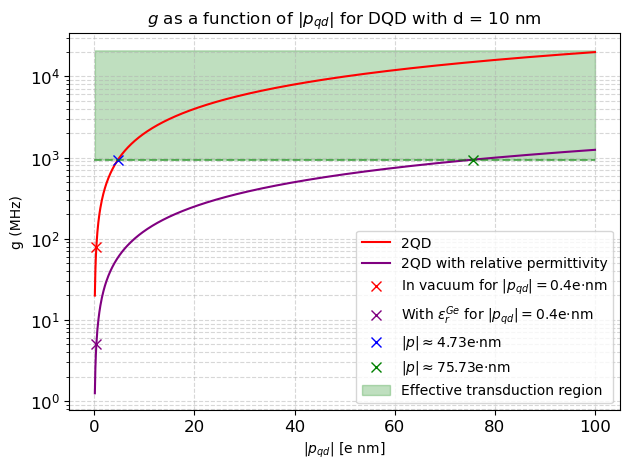

In [ ]:
#Find g as a func of p_emit 
p_range = np.linspace(0.1, 100, num=1000) #nm e  # Range of dipole moments in e

# Function to compute g as a function of p_emit only for DQD. 
def compute_g_vs_p_emit(p_vals):
    g_2d_values = []
    g_2d_dielec_values = []
    for p in p_vals:
        g_x_2d = compute_coupling(p_emit=[p*e0, 0, 0], emit_loc=[L_DQD_real+10, W_DQD_real, z_qubit], spin_loc=spin_qubit_loc_DQD)[1]*1e-6  # Convert to MHz
        g_x_2d_dielec = compute_dielecGe_coupling(p_emit=[p*e0, 0, 0], emit_loc=[L_DQD_real+10, W_DQD_real, z_qubit], spin_loc=spin_qubit_loc_DQD)[1]*1e-6
        g_2d_values.append(g_x_2d)
        g_2d_dielec_values.append(g_x_2d_dielec)
    g_2d_values = np.array(g_2d_values)
    # Here we find where the lines intersect with the decay rate area. 
    idxvac = np.where(np.diff(np.sign(g_2d_values - decay_rate)))[0] #Basically checks where the sign of the difference changes, indicating an intersection, and returning the indices of those points.
    idxdi = np.where(np.diff(np.sign(g_2d_values - decay_rate)))[0]
    if len(idxvac) > 0: #If we get a value, we can find the intersection point.
        i = idxvac[0]
        # Linear interpolation for more accurate intersection.
        x0, x1 = p_vals[i], p_vals[i+1]
        y0, y1 = g_2d_values[i], g_2d_values[i+1]
        p_cross = x0 + (decay_rate - y0) * (x1 - x0) / (y1 - y0) #This draws a line between the two points and finds the x-value where the line intersects with the decay rate.
        print(f"Intersection at |p_qd| ≈ {p_cross:.3f} e·nm")
    else: #No indices value found, so we set it to None.
        p_cross = None
        print("No intersection found.")
    if len(idxdi) > 0: #Same for the dielectric case.
        i = idxdi[0]
        x0, x1 = p_vals[i], p_vals[i+1]
        y0, y1 = g_2d_dielec_values[i], g_2d_dielec_values[i+1]
        p_cross_dielec = x0 + (decay_rate - y0) * (x1 - x0) / (y1 - y0)
        print(f"Intersection with dielectric at |p_qd| ≈ {p_cross_dielec:.3f} e·nm")
    else:
        p_cross_dielec = None
        print("No intersection with dielectric found.")
    fig, (ax2) = plt.subplots(nrows=1, ncols=1) #Then we olot. 
    ax2.plot(p_vals, g_2d_values, label='2QD', color='red')
    ax2.plot(p_vals, g_2d_dielec_values, label='2QD with relative permittivity', color='purple')
    ax2.plot(0.4, compute_coupling(p_emit=[0.4*e0, 0, 0], emit_loc=[L_DQD_real+10, W_DQD_real, z_qubit], spin_loc=spin_qubit_loc_DQD)[1]*1e-6, 'x', label='In vacuum for $|p_{qd}|=0.4$e·nm', markersize=7, color ='red')
    ax2.plot(0.4, compute_dielecGe_coupling(p_emit=[0.4*e0, 0, 0], emit_loc=[L_DQD_real+10, W_DQD_real, z_qubit], spin_loc=spin_qubit_loc_DQD)[1]*1e-6, 'x', label='With $\\varepsilon^{Ge}_r$ for $|p_{qd}|= 0.4$e·nm', markersize=7, color ='purple')
    ax2.plot(p_cross, decay_rate, 'x', label=f'$|p| \\approx  {p_cross:.2f}$e·nm', markersize=7, color='blue')
    ax2.plot(p_cross_dielec, decay_rate, 'x', label=f'$|p| \\approx  {p_cross_dielec:.2f}$e·nm', markersize=7, color='green')
    ax2.hlines(decay_rate, 0, max(p_vals), colors='green', linestyles='dashed', alpha = 0.5)
    ax2.fill_between(p_vals, decay_rate, ax2.get_ylim()[1], color='green', alpha=0.25, label='Effective transduction region')
    
    ax2.set_xlabel('$|p_{qd}|$ [e nm]')
    ax2.set_ylabel('g (MHz)')
    ax2.set_yscale('log')
    ax2.set_title('$g$ as a function of $|p_{qd}|$ for DQD with d = 10 nm', fontsize = 12)
    ax2.grid(True, which='both', linestyle='--', alpha=0.5)
    ax2.legend(fontsize=10, loc='lower right')
    ax2.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    #plt.savefig('g_vs_p_emit.png', dpi=500, bbox_inches='tight')
    plt.show()

compute_g_vs_p_emit(p_range)

#### Below we make the gridsearch function for P_r. Resulted in Fig. (5.1b). 

In [ ]:
#Here we scan over P_r for different orientations of the magnetic field.
def optimal_B_trial_SQD(B0, mat_params, lat_params, V, emit_loc, pos, p_emit):
        epsilon = 1e-2  # Small value to avoid division by zero
        theta_list = np.linspace(epsilon, np.pi-epsilon, num=10)  # List of theta and phi values to search over. 
        phi_list = np.linspace(epsilon, 2*np.pi-epsilon, num=10)
        beta = 0.98 #Set beta. 
        p_vals = np.zeros((len(theta_list), len(phi_list))) #Makes a 2D array of zeros to which we will assign the probabilities.
        for i in range(len(theta_list)): #Scans. 
            for j in range(len(phi_list)):
                theta = theta_list[i] #Assigns values. 
                phi = phi_list[j]

                B = [B0 * np.sin(theta) * np.cos(phi), B0 * np.sin(theta) * np.sin(phi), B0 * np.cos(theta)] #Finds B. 
        
                Ds, x01, y01, z01 = Ds_SQD_d01(mat_params, lat_params, B, V)[0:4] #Then using the above B, we find split and matrix elements. 

                ds_inhz = (1e-3 * (Ds * eV_to_J)) / h  # Convert to Hz
                p_spin = (np.array([x01, y01, z01]) * e0) * 1e-9  # Convert to C*m
                E_field = compute_emit_field(p_emit = p_emit, emit_loc = emit_loc, pos = pos) * 1e9  # Convert to V/m

                g = 2 * np.pi * (np.dot(p_spin, E_field) / h) #Then we compute the coupling strength g, to find P_r. 
                if g > ds_inhz:
                        p_vals[i,j] = (beta**2)
                else:
                        p_vals[i,j] = (beta**2)* ((g/ds_inhz)**2)
        return p_vals, theta_list, phi_list #Returns. 

p_valopt_x_SQD, theta_SQD, phi_SQD = optimal_B_trial_SQD(B0=0.5, mat_params=mat_params, lat_params=lat_params_SQD, V=-1000, emit_loc=[L_SQD_real+10, W_SQD_real/2, z_qubit], pos=[L_SQD_real/2, W_SQD_real/2, z_qubit], p_emit=[p_val, 0, 0])

#Same for the DQD setup. 
def optimal_B_trial_DQD(B0, mat_params, lat_params, emit_loc, pos, p_emit):
        epsilon = 1e-2
        theta_list = np.linspace(epsilon, np.pi-epsilon, num=10)
        phi_list = np.linspace(epsilon, 2*np.pi-epsilon, num=10)
        beta = 0.98
        p_vals = np.zeros((len(theta_list), len(phi_list)))
        g_vals = np.zeros((len(theta_list), len(phi_list)))
        omega_vals = np.zeros((len(theta_list), len(phi_list)))
        for i in range(len(theta_list)):
            for j in range(len(phi_list)):
                theta = theta_list[i]
                phi = phi_list[j]
                # Calculate B vector
                B = [B0 * np.sin(theta) * np.cos(phi), B0 * np.sin(theta) * np.sin(phi), B0 * np.cos(theta)]
                # Calculate g and energy split for this B
                Ds, x01, y01, z01 = Ds_DQD_d01(mat_params, lat_params, B)[0:4]

                ds_inhz = (1e-3 * (Ds * eV_to_J)) / h  # Convert to Hz
                p_spin = (np.array([x01, y01, z01]) * e0) * 1e-9  # Convert to C*m
                E_field = compute_emit_field(p_emit = p_emit, emit_loc = emit_loc, pos = pos) * 1e9  # Convert to V/m

                g = 2 * np.pi * (np.dot(p_spin, E_field) / h) 
                if g > ds_inhz:
                        p_vals[i,j] = (beta**2)
                else:
                        p_vals[i,j] = (beta**2)* ((g/ds_inhz)**2)
        return p_vals, theta_list, phi_list

p_valopt_x_DQD, theta_DQD, phi_DQD = optimal_B_trial_DQD(B0=0.5, mat_params=mat_params, lat_params=lat_params_DQD, emit_loc=[L_DQD_real+10, W_DQD_real/2, z_qubit], pos=[L_DQD_real/2, W_DQD_real/2, z_qubit], p_emit=[p_val, 0, 0])

Computing spin splitting and electric dipole moments for 1 qd with magnetic field B = [0.00499966667333327, 4.99983333555554e-05, 0.49997500020833263] T and gate voltage Vg = -1000.0 mV
Ds = 0.41193477641849086 meV
(1.0000000000000675+0j) (1.0000000000000966+0j)
x01_1well = 0.00281 nm
y01_1well = 0.00281 nm
z01_1well = 0.00005 nm
Computing spin splitting and electric dipole moments for 1 qd with magnetic field B = [0.0038050459017043305, 0.0032435770938426573, 0.49997500020833263] T and gate voltage Vg = -1000.0 mV
Ds = 0.4119322478452716 meV
(1.0000000000000568+0j) (1.0000000000000422+0j)
x01_1well = 0.00281 nm
y01_1well = 0.00281 nm
z01_1well = 0.00005 nm
Computing spin splitting and electric dipole moments for 1 qd with magnetic field B = [0.0008408578449308179, 0.004928704166654355, 0.49997500020833263] T and gate voltage Vg = -1000.0 mV
Ds = 0.4119338657984315 meV
(1.0000000000000557+0j) (1.0000000000000742+0j)
x01_1well = 0.00281 nm
y01_1well = 0.00281 nm
z01_1well = 0.00005 nm
C

In [ ]:
#Picks out n top values of p_r and their corresponding theta and phi angles
def top_n_pr(p_vals, theta_list, phi_list, n=3):
    flat_indices = np.argpartition(p_vals.flatten(), -n)[-n:] #This flattens the indices, so we can sort them. 
    sorted_indices = flat_indices[np.argsort(p_vals.flatten()[flat_indices])[::-1]] #Finds the indices of the top n values and sorts them in descending order.
    results = []
    for k in sorted_indices: #Then find the theta and phi values for these top values. 
        i, j = np.unravel_index(k, p_vals.shape)
        theta = theta_list[i]
        phi = phi_list[j]
        p_max = p_vals[i, j]
        results.append((p_max, np.degrees(theta), np.degrees(phi)))
    return results

#Prints top 3 values
top3_SQD = top_n_pr(p_valopt_x_SQD, theta_SQD, phi_SQD, n=3)
for i, (p, th, ph) in enumerate(top3_SQD, 1):
    print(f"Top {i}: p_r = {p:.4g} at theta = {th:.2f}°, phi = {ph:.2f}°")

top3_DQD = top_n_pr(p_valopt_x_DQD, theta_DQD, phi_DQD, n=3)
for i, (p, th, ph) in enumerate(top3_DQD, 1):
    print(f"Top {i}: p_r = {p:.4g} at theta = {th:.2f}°, phi = {ph:.2f}°")


Top 1: p_r = 0.001108 at theta = 80.06°, phi = 0.57°
Top 2: p_r = 0.001106 at theta = 80.06°, phi = 359.43°
Top 3: p_r = 0.0008235 at theta = 99.94°, phi = 199.94°


In [ ]:
#Plots heatmap
def plot_pr_heatmap(p_vals, theta_list, phi_list, title):
    plt.figure(figsize=(8, 6))
    X, Y = np.meshgrid(np.degrees(phi_list), np.degrees(theta_list))
    contour = plt.contourf(X, Y, p_vals, levels=300, cmap="OrRd")
    # Plot top 3 maxima as 'x'. Not used in discussion. 
    top3 = top_n_pr(p_vals, theta_list, phi_list, n=3)
    plt.xlabel(f'$\\phi$ (degrees)', fontsize=14)
    plt.ylabel(f'$\\theta$ (degrees)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=16)
    cbar = plt.colorbar(contour)
    cbar.set_label('$P_r$', fontsize=16) 
    cbar.ax.tick_params(labelsize=12)         
    plt.tight_layout()
    # Only show one legend entry for all x's
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend([handles[0]], ['Top 3 values'], loc='upper right')
    #plt.savefig('p_r_2d_10_10.png')
    plt.show()

#Prints the maximum p_r value and corresponding theta and phi angles, if we only want the maximum value.
def print_max_pr(p_vals, theta_list, phi_list, label):
    max_idx = np.unravel_index(np.argmax(p_vals), p_vals.shape)
    theta_max = theta_list[max_idx[0]]
    phi_max = phi_list[max_idx[1]]
    p_max = p_vals.max()
    print(rf"Max p_r for {label}: {p_max} at theta = {np.degrees(theta_max):.2f}°, phi = {np.degrees(phi_max):.2f}°")

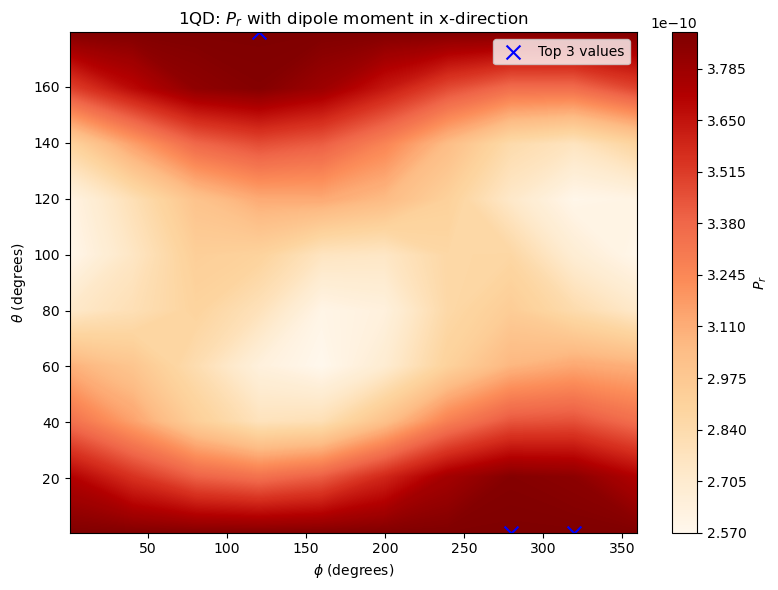

Max p_r for p_emit=[p_val,0,0]: 3.878967962684888e-10 at theta = 179.43°, phi = 120.19°


In [ ]:
plot_pr_heatmap(p_valopt_x_SQD, theta_SQD, phi_SQD, title='1QD: $P_r$ with dipole moment in x-direction')
print_max_pr(p_valopt_x_SQD, theta_SQD, phi_SQD, "p_emit=[p_val,0,0]")

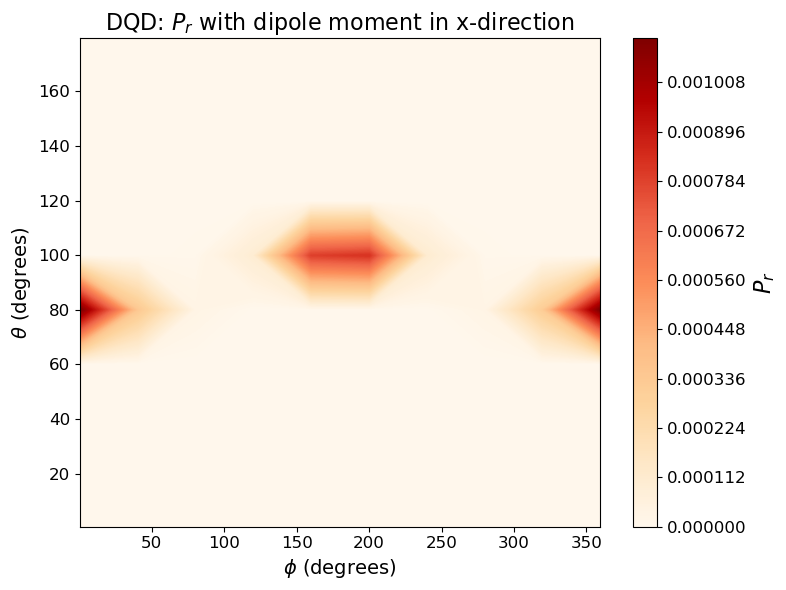

Max p_r for p_emit=[p_val,0,0]: 0.0011079316311499723 at theta = 80.06°, phi = 0.57°


In [ ]:
plot_pr_heatmap(p_valopt_x_DQD, theta_DQD, phi_DQD, title='DQD: $P_r$ with dipole moment in x-direction')
print_max_pr(p_valopt_x_DQD, theta_DQD, phi_DQD, "p_emit=[p_val,0,0]")

### Below we plot the gate potentials found in Appendix A. 

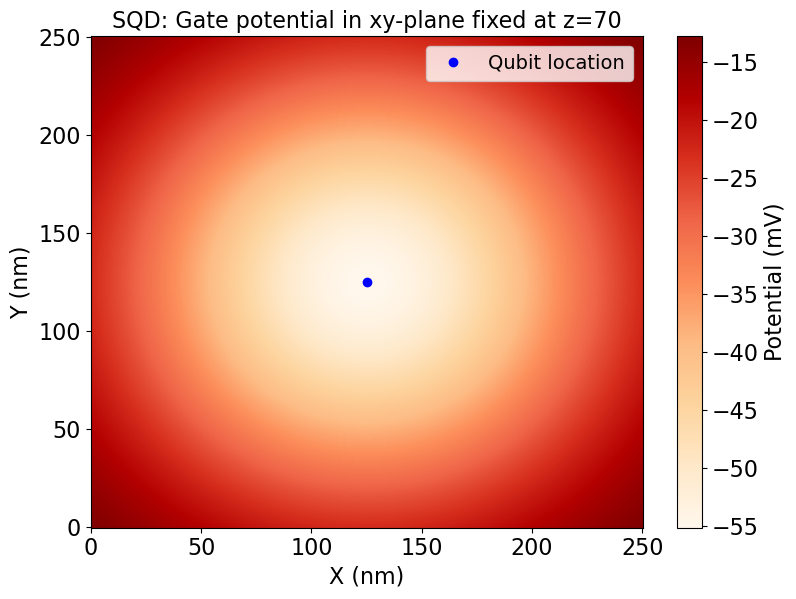

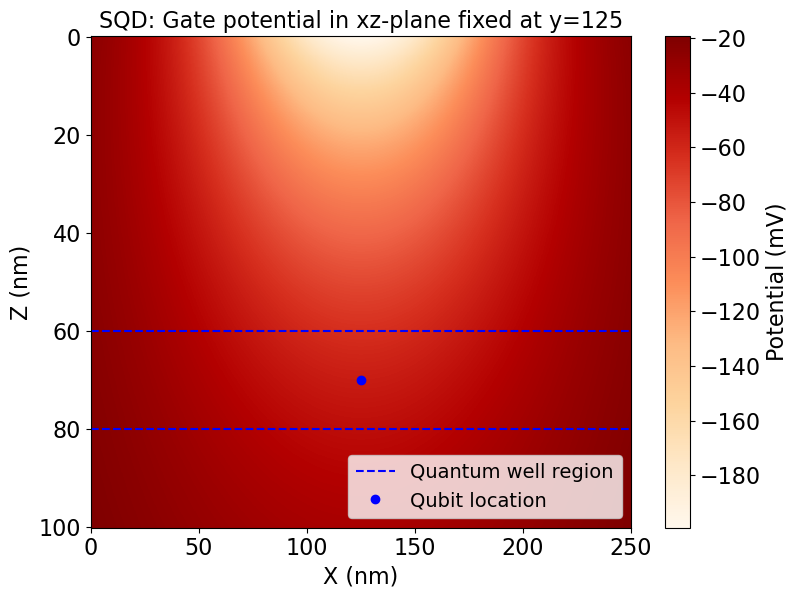

In [54]:
#Plotting the gate potential in xy plane for the SQD setup.
def plot_gate_potential_SQD_xy(V):
    x = np.linspace(0, L_SQD_real, 1000) #Makes a grid of points in the xy-plane.
    y = np.linspace(0, W_SQD_real, 1000)
    z = 70  #At qubit location. 

    X, Y = np.meshgrid(x, y, indexing='ij')
    V_grid = np.zeros_like(X)

    #Here we defined the same potential function as we did above, but since it is inside a function with other important parameters, we will just defined a new one here. 
    def potential(x, y, z):
        L = L_SQD_real/2 - 0.5*Lg
        R = L_SQD_real/2 + 0.5*Lg  
        B = W_SQD_real/2 - 0.5*Lg
        T = W_SQD_real/2 + 0.5*Lg
        return V * (g(x - L, y - B, z + d_QW) + g(x - L, T - y, z + d_QW) + g(R - x, y - B, z + d_QW) + g(R - x, T - y, z + d_QW))

    #Then we assign the potential values to the grid. 
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            V_grid[i, j] = potential(X[i, j], Y[i,j], z)
    #Plotting the potential in the xy-plane.
    plt.figure(figsize=(8, 6))
    c = plt.pcolormesh(X, Y, V_grid, cmap='OrRd', shading='auto')
    plt.title('SQD: Gate potential in xy-plane fixed at z=70', fontsize = 16)
    plt.plot(125,125, 'bo', label='Qubit location')
    plt.xlabel('X (nm)', fontsize = 16)
    plt.ylabel('Y (nm)', fontsize = 16)
    cbar = plt.colorbar(c, label='Potential (mV)')
    cbar.set_label('Potential (mV)', fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    plt.tight_layout()
    plt.legend(fontsize = 14, loc = 'upper right')
    plt.tick_params(labelsize=16)
    #plt.savefig('gate_potential_1qd_xy.png', dpi=300)
    plt.show()

#Plotting the gate potential in the xz-plane for the SQD setup. Same as above but here we fix the y-coordinate instead. 
def plot_gate_potential_SQD_xz(V):
    x = np.linspace(0, L_SQD_real, 1000)
    z = np.linspace(0, H_SQD_real, 1000)
    y = W_SQD_real/2  #Middle of the SQD on the y-axis. 

    X, Z = np.meshgrid(x, z, indexing='ij')
    V_grid = np.zeros_like(X)

    def potential(x, y, z):
        L = L_SQD_real/2 - 0.5*Lg
        R = L_SQD_real/2 + 0.5*Lg  
        B = W_SQD_real/2 - 0.5*Lg
        T = W_SQD_real/2 + 0.5*Lg
        return V * (g(x - L, y - B, z + d_QW) +g(x - L, T - y, z + d_QW) +g(R - x, y - B, z + d_QW) +g(R - x, T - y, z + d_QW))

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            V_grid[i, j] = potential(X[i, j], y, Z[i,j])

    plt.figure(figsize=(8, 6))
    c = plt.pcolormesh(X, Z, V_grid, cmap='OrRd', shading='auto')
    plt.title('SQD: Gate potential in xz-plane fixed at y=125', fontsize = 16)
    plt.xlabel('X (nm)', fontsize = 16)
    plt.ylabel('Z (nm)', fontsize = 16)
    plt.hlines(80, 0, L_SQD_real, colors='blue', linestyles='dashed')
    plt.hlines(60, 0, L_SQD_real, colors='blue', linestyles='dashed', label='Quantum well region')
    plt.plot(125, 70, 'bo', label='Qubit location')
    cbar = plt.colorbar(c, label='Potential (mV)')
    cbar.set_label('Potential (mV)', fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.legend(fontsize = 14, loc = 'lower right')
    plt.tick_params(labelsize=16)
    #plt.savefig('gate_potential_1qd_xz.png', dpi=300)
    plt.show()

#Plotting. 
plot_gate_potential_SQD_xy(V_SQD)
plot_gate_potential_SQD_xz(V_SQD)

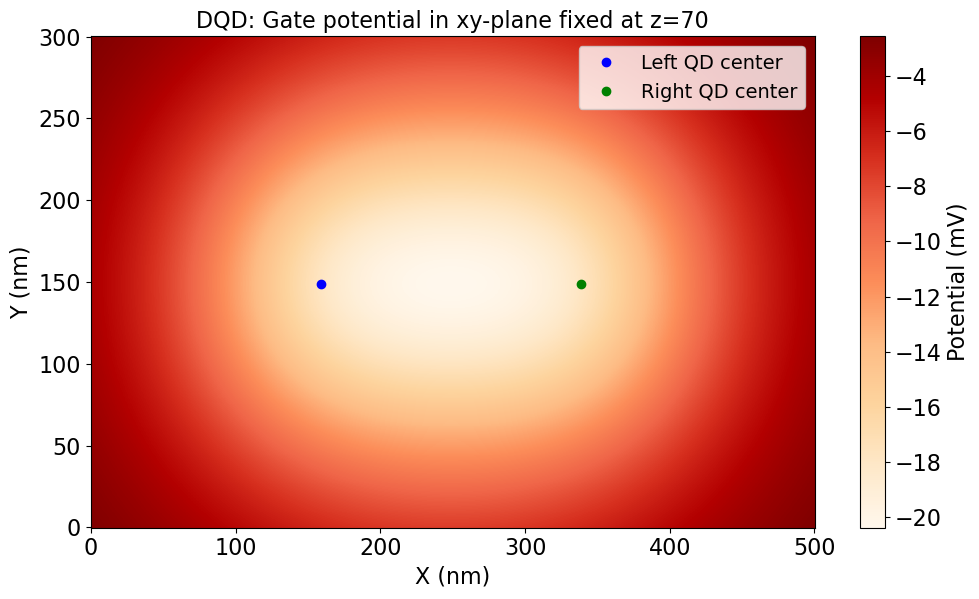

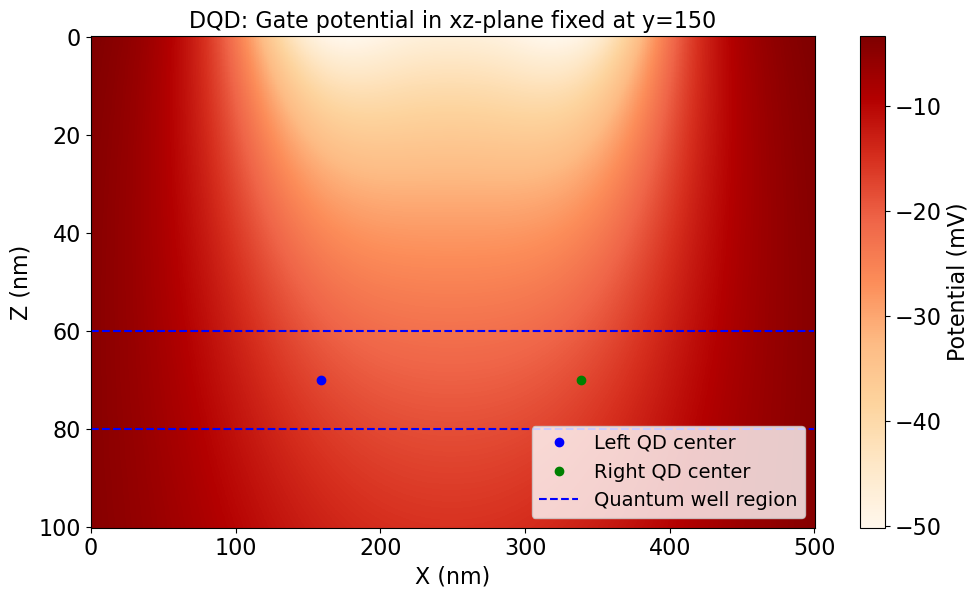

In [55]:
#Plotting the gate potential for DQD setup. First in the xy-plane. Again we defined the potnential function inside the function. 
def plot_gate_potentiaL_DQD_xy(V_L, V_R, V_B):
    x = np.linspace(0, L_DQD_real, 1000)
    y = np.linspace(0, W_DQD_real, 1000)
    z = 70  #qubit location. 

    X, Y = np.meshgrid(x, y, indexing='ij')
    V_grid = np.zeros_like(X)

    #Find the centers of the left and right quantum dots. 
    x0_left_center, x0_right_center = (L_DQD_real-dqw)/2 - 1, (L_DQD_real+dqw)/2 - 1
    y0_center = W_DQD_real/2  - 1 
    x0_barrier_gate_center = L_DQD_real/2  - 1

    #Then we defined each potential function for the left, right and barrier gate. 
    def left_potential(x, y, z):
        L = x0_left_center - 0.5*Lg 
        R = x0_left_center + 0.5*Lg  
        B = y0_center - 0.5*Lg 
        T = y0_center + 0.5*Lg
        return V_L * (g(x - L, y - B, z + z_dist) + g(x - L, T - y, z + z_dist) + g(R - x, y - B, z + z_dist) + g(R - x, T - y, z + z_dist))
    
    def right_potential(x, y, z):
        L = x0_right_center - 0.5*Lg 
        R = x0_right_center + 0.5*Lg  
        B = y0_center - 0.5*Lg 
        T = y0_center + 0.5*Lg
        return V_R * (g(x - L, y - B, z + z_dist) + g(x - L, T - y, z + z_dist) + g(R - x, y - B, z + z_dist) + g(R - x, T - y, z + z_dist))

    def barrier_potential(x, y, z):
        L = x0_barrier_gate_center - 0.5*Lg
        R = x0_barrier_gate_center + 0.5*Lg  
        B = y0_center - 0.5*Lg 
        T = y0_center + 0.5*Lg
        return V_B * (g(x - L, y - B, z + z_dist) + g(x - L, T - y, z + z_dist) + g(R - x, y - B, z + z_dist) + g(R - x, T - y, z + z_dist))
    
    #Assembling the total potential. 
    def potential (x,y,z):
        V_tot = (left_potential(x,y,z) + right_potential(x,y,z) + barrier_potential(x,y,z))
        return V_tot

    #Then we again assign the potential values to the grid.
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            V_grid[i, j] = potential(X[i, j], Y[i,j], z)
    #And plot. 
    plt.figure(figsize=(10, 6))
    c = plt.pcolormesh(X, Y, V_grid, cmap='OrRd', shading='auto')
    plt.title('DQD: Gate potential in xy-plane fixed at z=70', fontsize = 16)
    plt.plot(x0_left_center, y0_center, 'bo', label='Left QD center')
    plt.plot(x0_right_center, y0_center, 'go', label='Right QD center')
    plt.xlabel('X (nm)', fontsize = 16)
    plt.ylabel('Y (nm)', fontsize = 16)
    cbar = plt.colorbar(c)
    cbar.set_label('Potential (mV)', fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    plt.tight_layout()
    plt.legend(fontsize = 14, loc = 'upper right')
    plt.tick_params(labelsize=16)
    #plt.savefig('gate_potentiaL_DQD_xy.png', dpi=300)
    plt.show()

#Here we do it for the xz-plane. 
def plot_gate_potentiaL_DQD_xz(V_L, V_R, V_B):
    x = np.linspace(0, L_DQD_real, 1000)
    z = np.linspace(0, H_SQD_real, 1000)
    y =W_DQD_real/2  #Middle of the DQD on the y-axis. 

    X, Z = np.meshgrid(x, z, indexing='ij')
    V_grid = np.zeros_like(X)

    x0_left_center, x0_right_center = (L_DQD_real-dqw)/2 - 1, (L_DQD_real+dqw)/2 - 1
    y0_center = W_DQD_real/2  - 1 
    x0_barrier_gate_center = L_DQD_real/2  - 1

    def left_potential(x, y, z):
        L = x0_left_center - 0.5*Lg 
        R = x0_left_center + 0.5*Lg  
        B = y0_center - 0.5*Lg 
        T = y0_center + 0.5*Lg
        return V_L * (g(x - L, y - B, z + z_dist) + g(x - L, T - y, z + z_dist) + g(R - x, y - B, z + z_dist) + g(R - x, T - y, z + z_dist))
    
    def right_potential(x, y, z):
        L = x0_right_center - 0.5*Lg 
        R = x0_right_center + 0.5*Lg  
        B = y0_center - 0.5*Lg 
        T = y0_center + 0.5*Lg
        return V_R * (g(x - L, y - B, z + z_dist) + g(x - L, T - y, z + z_dist) + g(R - x, y - B, z + z_dist) + g(R - x, T - y, z + z_dist))
 
    def barrier_potential(x, y, z):
        L = x0_barrier_gate_center - 0.5*Lg 
        R = x0_barrier_gate_center + 0.5*Lg  
        B = y0_center - 0.5*Lg 
        T = y0_center + 0.5*Lg
        return V_B * (g(x - L, y - B, z + z_dist) + g(x - L, T - y, z + z_dist) + g(R - x, y - B, z + z_dist) + g(R - x, T - y, z + z_dist))
    
    def potential (x,y,z):
        V_tot = (left_potential(x,y,z) + right_potential(x,y,z) + barrier_potential(x,y,z))
        return V_tot

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            V_grid[i, j] = potential(X[i, j], y, Z[i,j])

    plt.figure(figsize=(10, 6))
    c = plt.pcolormesh(X, Z, V_grid, cmap='OrRd', shading='auto')
    plt.title('DQD: Gate potential in xz-plane fixed at y=150', fontsize = 16)
    plt.plot(x0_left_center, 70, 'bo', label='Left QD center')
    plt.plot(x0_right_center, 70, 'go', label='Right QD center')
    plt.hlines(80, 0, L_DQD_real, colors='blue', linestyles='dashed')
    plt.hlines(60, 0, L_DQD_real, colors='blue', linestyles='dashed', label='Quantum well region')
    plt.xlabel('X (nm)', fontsize = 16)
    plt.ylabel('Z (nm)', fontsize = 16)
    cbar = plt.colorbar(c)
    cbar.set_label('Potential (mV)', fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.legend(fontsize = 14, loc = 'lower right')
    plt.tick_params(labelsize=16)
    #plt.savefig('gate_potentiaL_DQD_xz.png', dpi=300)
    plt.show()

#Then we plot. 
plot_gate_potentiaL_DQD_xy(-200, -200, -130)
plot_gate_potentiaL_DQD_xz(-200, -200, -130)

#### And creating the streamplots for the emitter electric field. Here we create the figures second set of figures in Appendix A. 

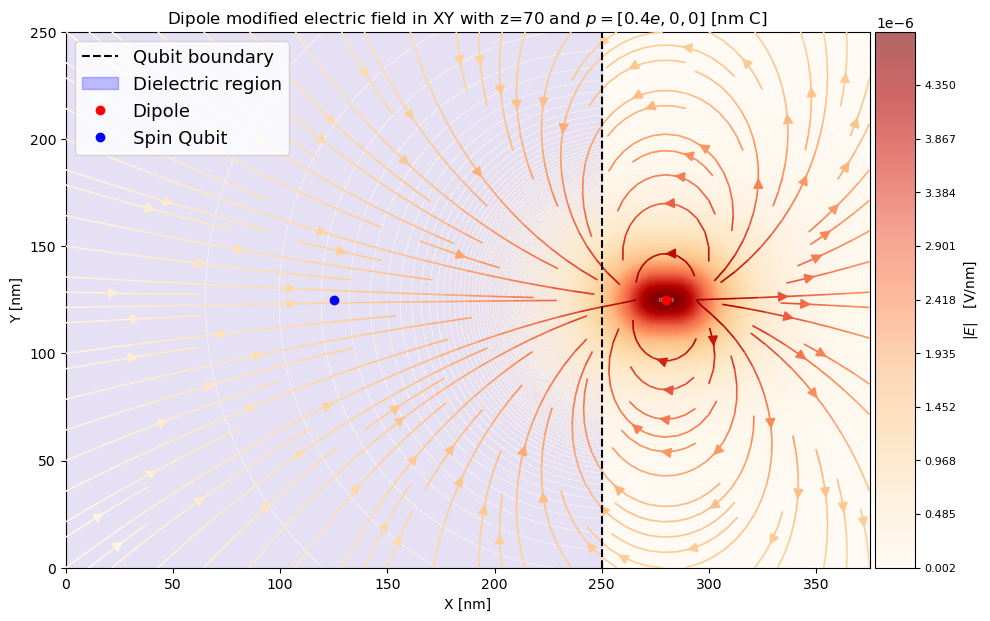

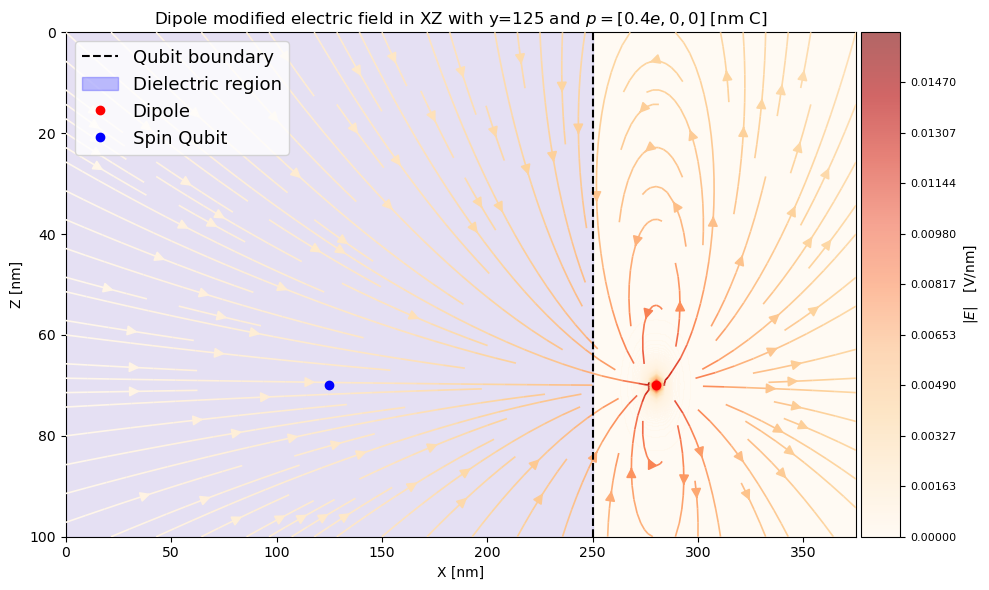

In [ ]:
#SQD field plotter
def e_field_SQD_plotterXY(p_emit, emit_loc, spin_loc):
    #Here we define the grid for the electric field. 
    x = np.linspace(0, L_SQD_real+L_SQD_real/2, num = 100) #Extend the x-axis so we can visualize the emitter outside the qubit. 
    y = np.linspace(0, W_SQD_real, num = 100)
    z = np.linspace(0, H_SQD_real, num = 100)

    well_dim = [L_SQD_real, W_SQD_real, H_SQD_real]

    X, Y, Z = np.meshgrid(x, y, z, indexing = 'ij')

    Ex = np.zeros_like(X)
    Ey = np.zeros_like(Y)
    Ez = np.zeros_like(Z)
    #Then we find the electric field at each point on the 3D grid.
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            for k in range(X.shape[2]):
                pos = np.array([X[i,j,k], Y[i,j, k], Z[i,j,k]])
                E = compute_dielecGe_emit_field(p_emit, emit_loc, pos) #Notice we use the dielectric field function as stated in Appendix A. 
                Ex[i, j, k] = E[0]
                Ey[i, j, k] = E[1]
                Ez[i, j, k] = E[2]
    epsilon = 1e-20 #Because we will use the log on our magnitude of the field. 
    
    mag = np.sqrt(Ex**2 + Ey**2 + Ez**2) #Find magnitude. 
    
    #For the XY plot we slice the grid in the middle of z. 
    z_index = X.shape[2] // 2
    X_XYslice = X[:, :, z_index].T #Transpose for streamplot. 
    Y_XYslice = Y[:, :, z_index].T

    Ex_XYslice = Ex[:, :, z_index].T #Also slice electric field. 
    Ey_XYslice = Ey[:, :, z_index].T

    mag_XYslice = mag[:, :, z_index].T #And magnitude

    log_mag = np.log10(mag_XYslice + epsilon)  #Take log of magnitude to visualize the field better, since it is very small. 

    levels_XY = np.linspace(np.nanmin(mag_XYslice), np.nanmax(mag_XYslice), 1000) #Here we define the levels for the contour plot. nanmin and nanmax are used to avoid unavailable values and just returns 0. 

    fig, ax = plt.subplots(figsize=(10, 8)) #Subplot. 
    #Divider and cax are just used to make the colorbar look nice on the plot, for formatting purposes. There were suggested by CoPilot. 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.axvline(x=L_SQD_real, color = 'black', linestyle = 'dashed', linewidth = 1.5, zorder = 8, label = 'Qubit boundary') #Define the qubit boundary.
    #Here we make the streamplot and contour plot.
    strm = ax.streamplot(X_XYslice, Y_XYslice, Ex_XYslice, Ey_XYslice, color=log_mag, linewidth=1.2, density=1.2, cmap='OrRd', zorder=3, arrowsize=1.5)
    cp = ax.contourf(X_XYslice, Y_XYslice, mag_XYslice, levels=levels_XY, zorder=2, cmap='OrRd', alpha=0.6)
    cbar = fig.colorbar(cp, cax=cax, label=f'$|E|\quad$[V/nm]', pad=0.02, aspect=30, orientation='vertical') #Colorbar. 
    cbar.ax.tick_params(labelsize=8) #To adjust the colorbar labels.
    ax.axvspan(0, L_SQD_real, alpha=0.25, color='blue', label='Dielectric region') #To show the qubit region. 
    ax.set_aspect('equal') #Formatting the plot. 
    #These are here to plot where the emitter and qubit are located. 
    ax.plot(emit_loc[0], emit_loc[1], 'ro', label = 'Dipole', zorder = 4)
    ax.plot(spin_loc[0], spin_loc[1], 'bo', label = 'Spin Qubit', zorder = 5)
    ax.set_xlabel(f'X [nm]')
    ax.set_ylabel(f'Y [nm]')
    ax.set_xlim([X_XYslice.min(), X_XYslice.max()])
    ax.set_ylim([Y_XYslice.min(), Y_XYslice.max()])
    ax.set_aspect('equal')
    ax.legend(loc='upper left', fontsize=13, frameon=True)
    ax.set_title(f'Dipole modified electric field in XY with z=70 and $p=[0.4e, 0, 0]$ [nm C]')
    plt.tight_layout()
    #plt.savefig('dipole_fieldXY.png', dpi=300)
    plt.show()

#Same for the XZ plot, but here we slice y. 
def e_field_SQD_plotterXZ(p_emit, emit_loc, spin_loc):

    x = np.linspace(0, L_SQD_real+L_SQD_real/2, num = 100)
    y = np.linspace(0, W_SQD_real, num = 100)
    z = np.linspace(0, H_SQD_real, num = 100)

    well_dim = [L_SQD_real, W_SQD_real, H_SQD_real]

    X, Y, Z = np.meshgrid(x, y, z, indexing = 'ij')

    Ex = np.zeros_like(X)
    Ey = np.zeros_like(Y)
    Ez = np.zeros_like(Z)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            for k in range(X.shape[2]):
                pos = np.array([X[i,j,k], Y[i,j, k], Z[i,j,k]])
                E = compute_dielecGe_emit_field(p_emit, emit_loc, pos)
                Ex[i, j, k] = E[0]
                Ey[i, j, k] = E[1]
                Ez[i, j, k] = E[2]
    epsilon = 1e-20
    
    mag = np.sqrt(Ex**2 + Ey**2 + Ez**2)
    #The XY plot 
    y_index = X.shape[1] // 2
    X_XZslice = X[:, y_index, :].T
    Z_XZslice = Z[:, y_index, :].T

    Ex_XZslice = Ex[:, y_index, :].T
    Ez_XZslice = Ez[:, y_index, :].T

    mag_XZslice = mag[:, y_index, :].T

    log_mag = np.log10(mag_XZslice + epsilon)  

    levels_XZ = np.linspace(np.nanmin(mag_XZslice), np.nanmax(mag_XZslice), 1000)

    fig, ax = plt.subplots(figsize=(10, 6))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.axvline(x=L_SQD_real, color = 'black', linestyle = 'dashed', linewidth = 1.5, zorder = 8, label = 'Qubit boundary')

    strm = ax.streamplot(X_XZslice, Z_XZslice, Ex_XZslice, Ez_XZslice, color=log_mag, linewidth=1.2, density=1.2, cmap='OrRd', zorder=3, arrowsize=1.5)
    cp = ax.contourf(X_XZslice, Z_XZslice, mag_XZslice, levels=levels_XZ, zorder=2, cmap='OrRd', alpha=0.6)
    cbar = fig.colorbar(cp, cax=cax, label=f'$|E|\quad$[V/nm]', pad=0.02, aspect=30, orientation='vertical')
    cbar.ax.tick_params(labelsize=8)
    ax.axvspan(0, L_SQD_real, alpha=0.25, color='blue', label='Dielectric region')
    ax.plot(emit_loc[0], emit_loc[2], 'ro', label = 'Dipole', zorder = 4)
    ax.plot(spin_loc[0], spin_loc[2], 'bo', label = 'Spin Qubit', zorder = 5)
    ax.set_xlabel(f'X [nm]')
    ax.set_ylabel(f'Z [nm]')
    ax.set_xlim([X_XZslice.min(), X_XZslice.max()])
    ax.set_ylim([Z_XZslice.min(), Z_XZslice.max()])
    ax.set_aspect('auto')
    ax.invert_yaxis()
    ax.legend(loc='upper left', fontsize=13, frameon=True)
    ax.set_title(f'Dipole modified electric field in XZ with y=125 and $p=[0.4e, 0, 0]$ [nm C]')
    plt.tight_layout()
    #plt.savefig('dipole_fieldXZ.png', dpi=300)
    plt.show()

e_field_SQD_plotterXY(p_emit=[p_val, 0, 0,], emit_loc=[L_SQD_real+30, W_SQD_real/2, z_qubit], spin_loc=spin_qubit_loc_SQD)
e_field_SQD_plotterXZ(p_emit=[p_val, 0, 0,], emit_loc=[L_SQD_real+30, W_SQD_real/2, z_qubit], spin_loc=spin_qubit_loc_SQD)

### And that concludes the simulation document. 